In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_curve, auc,accuracy_score,classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor,plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.neighbors import KernelDensity
from scipy import stats

In [2]:
df=pd.read_csv("C:/Users/sambi/Downloads/data.csv")

In [3]:
df["Bankrupt?"].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

In [3]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Set a threshold for what you consider a high correlation (e.g., 0.7 for high positive and -0.7 for high negative)
threshold =0.999

# Create a mask for highly positively correlated columns
high_positive_corr = correlation_matrix > threshold

# Create a mask for highly negatively correlated columns
high_negative_corr = correlation_matrix < -threshold

# Get the column pairs with high positive and negative correlations
high_positive_corr_pairs = [(col1, col2) for col1 in df.columns for col2 in df.columns if high_positive_corr.loc[col1, col2] and col1 != col2]
high_negative_corr_pairs = [(col1, col2) for col1 in df.columns for col2 in df.columns if high_negative_corr.loc[col1, col2] and col1 != col2]

print("Highly positively correlated column pairs:")
print(high_positive_corr_pairs)

print("\nHighly negatively correlated column pairs:")
print(high_negative_corr_pairs)


Highly positively correlated column pairs:
[(' Operating Gross Margin', ' Realized Sales Gross Margin'), (' Operating Gross Margin', ' Gross Profit to Sales'), (' Realized Sales Gross Margin', ' Operating Gross Margin'), (' Realized Sales Gross Margin', ' Gross Profit to Sales'), (' Net Value Per Share (B)', ' Net Value Per Share (A)'), (' Net Value Per Share (B)', ' Net Value Per Share (C)'), (' Net Value Per Share (A)', ' Net Value Per Share (B)'), (' Net Value Per Share (A)', ' Net Value Per Share (C)'), (' Net Value Per Share (C)', ' Net Value Per Share (B)'), (' Net Value Per Share (C)', ' Net Value Per Share (A)'), (' Current Liabilities/Liability', ' Current Liability to Liability'), (' Current Liabilities/Equity', ' Current Liability to Equity'), (' Current Liability to Liability', ' Current Liabilities/Liability'), (' Current Liability to Equity', ' Current Liabilities/Equity'), (' Gross Profit to Sales', ' Operating Gross Margin'), (' Gross Profit to Sales', ' Realized Sales 

In [4]:
# I will remove ' Gross Profit to Sales',' Current Liability to Liability',' Current Liability to Equity',' Operating Gross Margin',' Realized Sales Gross Margin',' Net Value Per Share (C)',' Net Value Per Share (B)',' Debt ratio %'

In [5]:
df=df.drop([' Gross Profit to Sales',' Current Liability to Liability',' Current Liability to Equity',' Operating Gross Margin',' Realized Sales Gross Margin',' Net Value Per Share (C)',' Net Value Per Share (B)',' Debt ratio %'],axis=1)

In [6]:
X=df.drop(columns=["Bankrupt?"])
Y=df["Bankrupt?"]

In [7]:
df.shape

(6819, 88)

In [8]:
# Integer valued column
intcol=X.select_dtypes(["int","int64","int32"])
u=list(intcol.columns)
print(u)

[' Liability-Assets Flag', ' Net Income Flag']


In [9]:
# Train Test Split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42,shuffle=True)

In [10]:
#Fetching the indices of categorical features from X_train

index1 = X_train.columns.get_loc(' Liability-Assets Flag')
index2 = X_train.columns.get_loc(' Net Income Flag')

print(index1,index2)

77 85


In [11]:
# SMOTENC on training data

smote_sample=SMOTENC(categorical_features=[77,85],sampling_strategy="auto",random_state=2000,k_neighbors=5)
X_train_smote,Y_train_smote=smote_sample.fit_resample(X_train,Y_train)

In [12]:
# Few checkings of counts

print(np.bincount(Y_train))
print(np.bincount(Y_train_smote))
print(np.bincount(X_train_smote.iloc[:,77]))
print(np.bincount(X_train_smote.iloc[:,85]))

[4631  142]
[4631 4631]
[9257    5]
[   0 9262]


In [13]:
# Standardrization 

scalar=StandardScaler()
X_train_smote_std=scalar.fit_transform(X_train_smote)
X_test_std=scalar.transform(X_test)

In [14]:
# Lasso Logistic
X_train_smote.shape



(9262, 87)

In [15]:
# Choosing the value of alpha

X_train_smote_=sm.add_constant(X_train_smote_std)
X_test_=sm.add_constant(X_test_std)
ridge_reg=sm.Logit(Y_train_smote,X_train_smote_)

In [ ]:
mean=[]
c=[]
for i in range(10,200,6):
    try:
        ridge_reg_results1=ridge_reg.fit_regularized(alpha=i,L1_wt=0.0)        coefficients1=ridge_reg_results1.params
        df3=pd.DataFrame(coefficients1)
        v1=X.columns.insert(0,"Constant")
        df3.set_index(v1,inplace=True)
        drop_col1=df3[(-0.0005<df3[0])&(df3[0]<0.0005)].index
        if "Constant" in drop_col1:
            drop_col1=drop_col1.delete(0)
        df2=pd.DataFrame(X_train_smote_std)  #columns=df.columns
        #data00=df2.drop(drop_col1,axis=1)
        #data_mult2=data00.drop(["Bankrupt?"],axis=1)
        data_mult2=df2.drop(drop_col1,axis=1)
        vif_data1 = pd.DataFrame()
        vif_data1["feature"] = data_mult2.columns
        vif_data1["VIF"] = [variance_inflation_factor(data_mult2.values, i)
                          for i in range(len(data_mult2.columns))]
        mean.append(vif_data1["VIF"].mean())
        c.append(i)
    except:
        continue

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3233827491746608
            Iterations: 140
            Function evaluations: 140
            Gradient evaluations: 140
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.327431469266323
            Iterations: 136
            Function evaluations: 136
            Gradient evaluations: 136
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.33137156597623607
            Iterations: 140
            Function evaluations: 140
            Gradient evaluations: 140


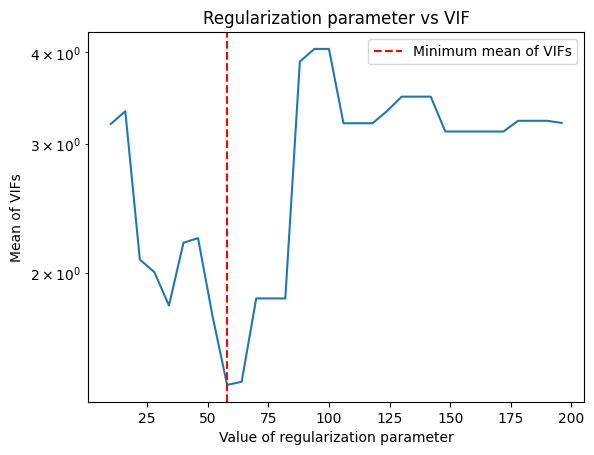

In [27]:
min_mean=min(mean)
min_x_mean = c[mean.index(min_mean)]
#plt.figure(figsize=(8, 6))
sns.lineplot(x=c,y=mean)
plt.yscale('log')
plt.xlabel("Value of regularization parameter")
plt.axvline(x=min_x_mean, color='red', linestyle='--', label='Minimum mean of VIFs')
#plt.text(min_x_mean, -0.2, f'Min x: {min_x_mean}', color='red', ha='center')
plt.ylabel("Mean of VIFs")
plt.legend()
plt.title("Regularization parameter vs VIF")
#plt.text(22, -0.2, 'x=22', color='green', ha='center')
plt.show()

In [16]:
# Lasso logistic using the optimal value of alpha

ridge_reg_results2=ridge_reg.fit_regularized(alpha=58,L1_wt=0.0)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3149274120665668
            Iterations: 153
            Function evaluations: 153
            Gradient evaluations: 153


In [17]:
#print(ridge_reg_results.summary())
print(ridge_reg_results2.summary())

                           Logit Regression Results                           
Dep. Variable:              Bankrupt?   No. Observations:                 9262
Model:                          Logit   Df Residuals:                     9241
Method:                           MLE   Df Model:                           20
Date:                Sat, 11 Nov 2023   Pseudo R-squ.:                  0.6066
Time:                        05:32:24   Log-Likelihood:                -2525.7
converged:                       True   LL-Null:                       -6419.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const               0        nan        nan        nan         nan         nan
x1                  0        nan        nan        nan         nan         nan
x2                  0        nan        nan        n

In [18]:
coefficients2=ridge_reg_results2.params
df4=pd.DataFrame(coefficients2)
v1=X.columns.insert(0,"Constant")
df4.set_index(v1,inplace=True)

In [19]:
df4.head(100)

,0
Constant,0.000000
ROA(C) before interest and depreciation before interest,0.000000
ROA(A) before interest and % after tax,0.000000
ROA(B) before interest and depreciation after tax,0.000000
Operating Profit Rate,0.029024
...,...
Liability to Equity,0.000000
Degree of Financial Leverage (DFL),0.023968
Interest Coverage Ratio (Interest expense to EBIT),0.000000
Net Income Flag,0.000000


In [20]:
print("Number of columns having 0 coefficients is ",df4[(-0.0005<df4[0])&(df4[0]<0.0005)].size)

Number of columns having 0 coefficients is  68


In [21]:
# Dropping variables from the dataset

drop_col1=df4[(-0.0005<df4[0])&(df4[0]<0.0005)].index
drop_col1=drop_col1.delete(0)
df5=pd.DataFrame(X_train_smote,columns=X.columns)
df6=pd.DataFrame(X_test,columns=X.columns)


In [22]:
X_train1=X_train_smote.drop(drop_col1,axis=1)
X_test1=X_test.drop(drop_col1,axis=1)

In [23]:
X_train1_std=scalar.fit_transform(X_train1)
X_test1_std=scalar.transform(X_test1)

In [24]:
d=pd.DataFrame(X_train1_std)

In [25]:
vif_data1 = pd.DataFrame()
vif_data1["feature"] = X_train1.columns
vif_data1["VIF"] = [variance_inflation_factor(d.values, i)
                          for i in range(len(d.columns))]

In [26]:
vif_data1

,feature,VIF
0,Operating Profit Rate,1.009313
1,Persistent EPS in the Last Four Seasons,2.700170
2,Regular Net Profit Growth Rate,1.262010
3,Cash Reinvestment %,1.221634
4,Total debt/Total net worth,1.041811
5,Net worth/Assets,2.383240
6,Accounts Receivable Turnover,1.008395
7,Average Collection Days,1.001339
8,Inventory Turnover Rate (times),1.077750
9,Fixed Assets Turnover Frequency,1.144132


In [27]:
vif_data1.to_excel("abc.xlsx", sheet_name="1", index=False)

In [28]:
vif_data1["VIF"].mean()

1.407183285318259

In [29]:
# Now we will use X_train1(Y_train_smote),X_test1(Y_test) for standard scalar. Them we can use this for further models.
# Standarization


X_train2=scalar.fit_transform(X_train1)
X_test2=scalar.transform(X_test1)
Y_train2=Y_train_smote
Y_test2=Y_test




In [30]:
#Logistic regression

X_train2_cons=sm.add_constant(X_train2)
X_test2_cons=sm.add_constant(X_test2)
lr=sm.Logit(Y_train2,X_train2_cons)

In [44]:
lr_result=lr.fit()

         Current function value: 0.262524
         Iterations: 35


c:\users\arghadeep fadikar\appdata\local\programs\python\python39\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\users\arghadeep fadikar\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [45]:
lr_result.summary()

c:\users\arghadeep fadikar\appdata\local\programs\python\python39\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Bankrupt?   No. Observations:                 9262
Model:                          Logit   Df Residuals:                     9241
Method:                           MLE   Df Model:                           20
Date:                Sun, 05 Nov 2023   Pseudo R-squ.:                  0.6213
Time:                        11:20:09   Log-Likelihood:                -2431.5
converged:                      False   LL-Null:                       -6419.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4045   8.27e+04  -4.89e-06      1.000   -1.62e+05    1.62e+05
x1             1.2967      0.404      3.213      0.001       0.506       2.088
x2            -1.4953      0.139    -10.793      0.000      -1.767      -1.224
x3             0.1974      0.076      2.611      0.009       0.049       0.346
x4             0.2522      0.054      4.712      0.000       0.147       0.357
x5             0.1726      0.033      5.223      0.000       0.108       0.237
x6            -2.2906      0.080    -28.592      0.000      -2.448      -2.134
x7            -0.5711      0.156     -3.655      0.000      -0.877      -0.265
x8           -12.3102   3.66e+06  -3.36e-06      1.000   -7.18e+06    7.18e+06
x9            -0.1887      0.038     -4.905      0.000      -0.264      -0.113
x10            0.1943      0.037      5.290      0.000       0.122       0.266
x11           -0.4926      0.057     -8.598      0.000      -0.605      -0.380
x12           -0.5621      0.073     -7.661      0.000      -0.706      -0.418
x13            0.3619      0.043      8.496      0.000       0.278       0.445
x14           -0.1248      0.047     -2.645      0.008      -0.217      -0.032
x15           -0.2738      0.043     -6.390      0.000      -0.358      -0.190
x16           -0.6877      0.044    -15.762      0.000      -0.773      -0.602
x17           -0.4437      0.046     -9.634      0.000      -0.534      -0.353
x18           -0.0886      0.047     -1.898      0.058      -0.180       0.003
x19           -1.5272      0.143    -10.672      0.000      -1.808      -1.247
x20            0.0766      0.028      2.748      0.006       0.022       0.131
==============================================================================
"""

In [49]:
lr_coef=pd.DataFrame(lr_result.params)

In [50]:
lr_coef.to_excel("lr_coef.xlsx", sheet_name="1")

In [47]:
y_pred_log=lr_result.predict(X_test2_cons)

In [34]:
fpr_log, tpr_log, thresholds_log = roc_curve(Y_test2, y_pred_log)

In [35]:
roc_auc_log = auc(fpr_log, tpr_log)
print("AUC: ",roc_auc_log)

AUC:  0.9259367834062956


In [36]:
diff_log=tpr_log-fpr_log
best_arg_log=np.argmax(diff_log)
opt_thresold_log=thresholds_log[best_arg_log]
print("Best Threshold:", opt_thresold_log)
print("Corresponding TPR/Sensitivity:", tpr_log[best_arg_log])
print("Corresponding Specificity:", 1-fpr_log[best_arg_log])

Best Threshold: 0.2833738501176111
Corresponding TPR/Sensitivity: 0.9230769230769231
Corresponding Specificity: 0.8135162601626016


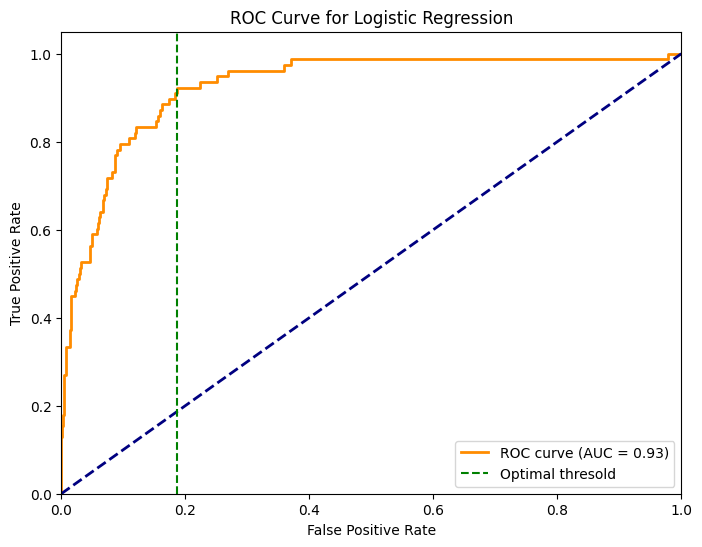

In [37]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_log:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.axvline(x=fpr_log[best_arg_log], color='green', linestyle='--', label='Optimal thresold')
plt.legend(loc='lower right')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()

In [39]:
y_pred_log_binary = (y_pred_log >= opt_thresold_log).astype(int)
f1scoref1 = f1_score(Y_test2, y_pred_log_binary)
print("F1 score:", f1scoref1)

F1 score: 0.27852998065764023


In [38]:
y_pred_log_binary

array([0, 0, 0, ..., 0, 0, 0])

In [40]:
cm_lr=confusion_matrix(Y_test2, y_pred_log_binary)

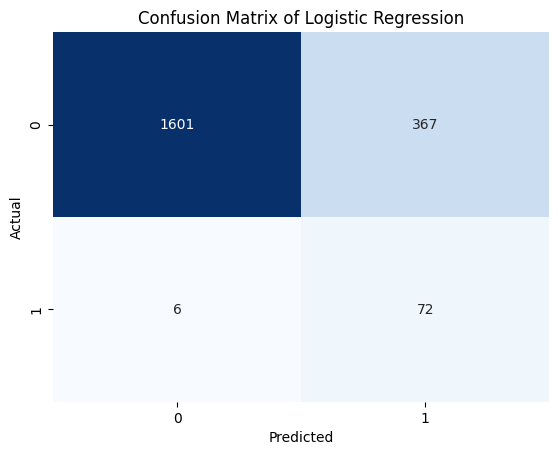

In [43]:
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Logistic Regression')
plt.show()

In [41]:
precision = precision_score(Y_test2, y_pred_log_binary)
recall = recall_score(Y_test2, y_pred_log_binary)

In [42]:
recall

0.9230769230769231

In [43]:
precision

0.16400911161731208

In [44]:
TP = cm_lr[0, 0]
TN = cm_lr[1, 1]
FP = cm_lr[0, 1]
FN = cm_lr[1, 0]

In [45]:
TP/(TP+FP)

0.8135162601626016

In [46]:
np.bincount(Y_test2)

array([1968,   78], dtype=int64)

In [53]:
# KNN

k_values=list(range(1,40))
knn_metric=[]
for k in k_values:
    knn_k=KNeighborsClassifier(n_neighbors=k)
    knn_k.fit(X_train2,Y_train2)
    #y_pred_knn_k=knn.predict(X_test2)
    y_prob_knn_k = knn_k.predict_proba(X_test2)[:, 1]
    fpr_knn_k, tpr_knn_k, thresholds_knn_k = roc_curve(Y_test2, y_prob_knn_k)
    diff_knn_k=tpr_knn_k-fpr_knn_k
    knn_metric.append(max(diff_knn_k))

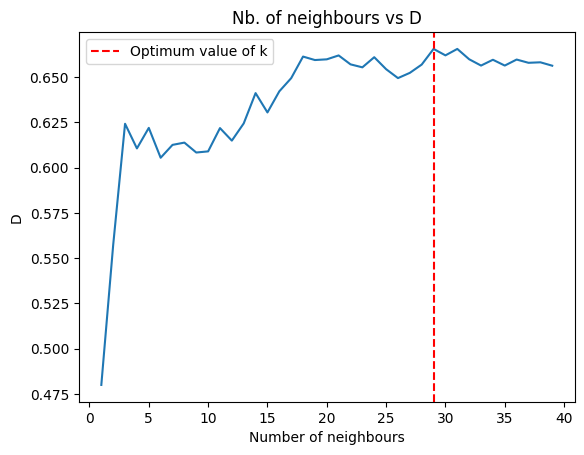

In [64]:

sns.lineplot(x=k_values,y=knn_metric)
k_opt=k_values[np.argmax(np.array(knn_metric))]
plt.axvline(x=k_opt, color='red', linestyle='--', label='Optimum value of k')
plt.legend()
plt.xlabel("Number of neighbours")
plt.ylabel("D")
plt.title("Nb. of neighbours vs D")
plt.show()

In [55]:
k_opt

29

In [128]:
k_values=list(range(1,100))
knn_metric1=[]
for k in k_values:
    knn_k=KNeighborsClassifier(n_neighbors=k)
    knn_k.fit(X_train2,Y_train2)
    #y_pred_knn_k=knn.predict(X_test2)
    y_prob_knn_k = knn_k.predict_proba(X_test2)[:, 1]
    fpr_knn_k, tpr_knn_k, thresholds_knn_k = roc_curve(Y_test2, y_prob_knn_k)
    diff_knn_k=tpr_knn_k-fpr_knn_k
    knn_metric1.append(auc(fpr_knn_k, tpr_knn_k))

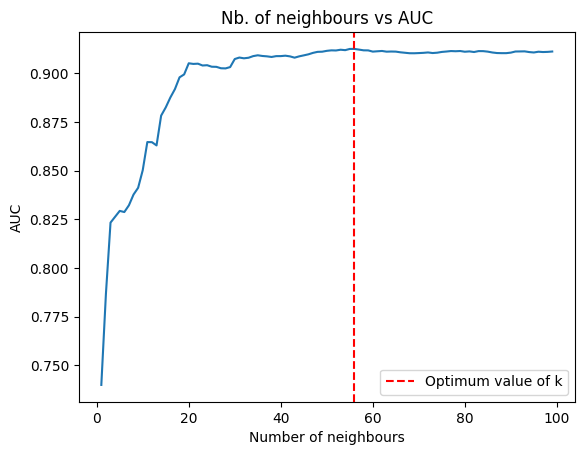

In [138]:
sns.lineplot(x=k_values,y=knn_metric1)
k_opt1=k_values[np.argmax(np.array(knn_metric1))]
plt.axvline(x=k_opt1, color='red', linestyle='--', label='Optimum value of k')
plt.legend()
plt.xlabel("Number of neighbours")
plt.ylabel("AUC")
plt.title("Nb. of neighbours vs AUC")
plt.show()

In [139]:
k_opt1

56

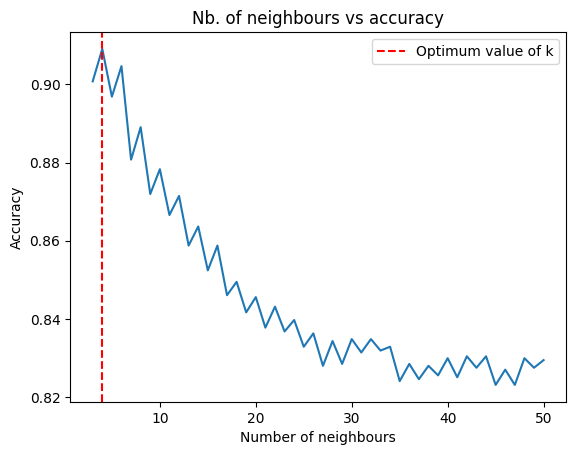

In [48]:

# sns.lineplot(x=k_values,y=knn_accuracy)
# k_opt=k_values[np.argmax(np.array(knn_accuracy))]
# plt.axvline(x=k_opt, color='red', linestyle='--', label='Optimum value of k')
# plt.legend()
# plt.xlabel("Number of neighbours")
# plt.ylabel("Accuracy")
# plt.title("Nb. of neighbours vs accuracy")
# plt.show()

In [130]:
knn=KNeighborsClassifier(n_neighbors=k_opt1)
knn.fit(X_train2,Y_train2)
y_pred_knn=knn.predict(X_test2)

In [131]:
y_prob_knn = knn.predict_proba(X_test2)[:, 1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(Y_test2, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)
print("AUC: ",roc_auc_knn)

AUC:  0.9124876224723786


In [132]:
diff_knn=tpr_knn-fpr_knn
best_arg_knn=np.argmax(diff_knn)
opt_thresold_knn=thresholds_knn[best_arg_knn]
print("Best Threshold:", opt_thresold_knn)
print("Corresponding TPR/Sensitivity:", tpr_knn[best_arg_knn])
print("Corresponding Specificity:", 1-fpr_knn[best_arg_knn])

Best Threshold: 0.48214285714285715
Corresponding TPR/Sensitivity: 0.8717948717948718
Corresponding Specificity: 0.8109756097560976


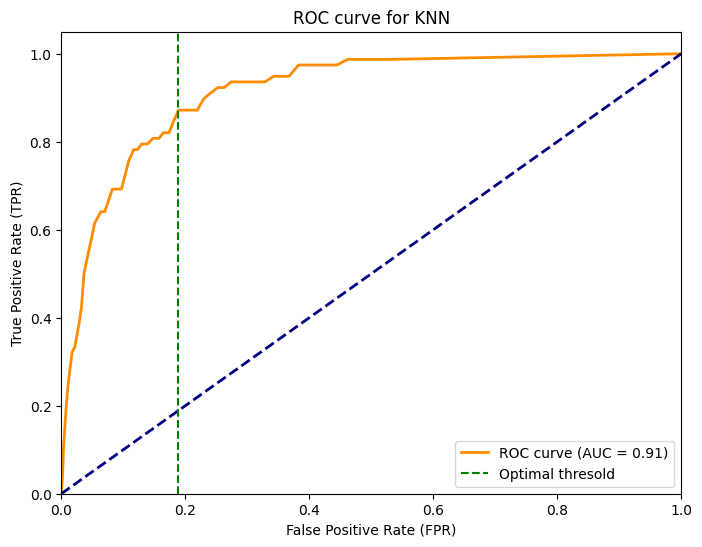

In [133]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_knn))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.axvline(x=fpr_knn[best_arg_knn], color='green', linestyle='--', label='Optimal thresold')
plt.legend(loc='lower right')
plt.title('ROC curve for KNN')
plt.legend(loc='lower right')
plt.show()

In [134]:
y_pred_knn_binary = (y_prob_knn >= thresholds_knn[best_arg_knn]).astype(int)
f1scoref1 = f1_score(Y_test2, y_pred_knn_binary)
print("F1 score:", f1scoref1)

F1 score: 0.2625482625482625


In [135]:
cm_knn=confusion_matrix(Y_test2, y_pred_knn_binary)

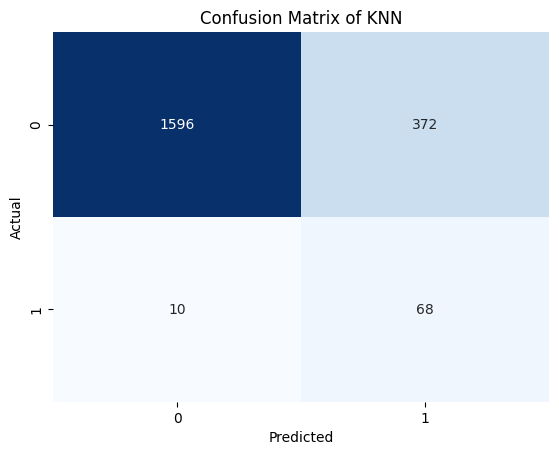

In [136]:
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of KNN')
plt.show()

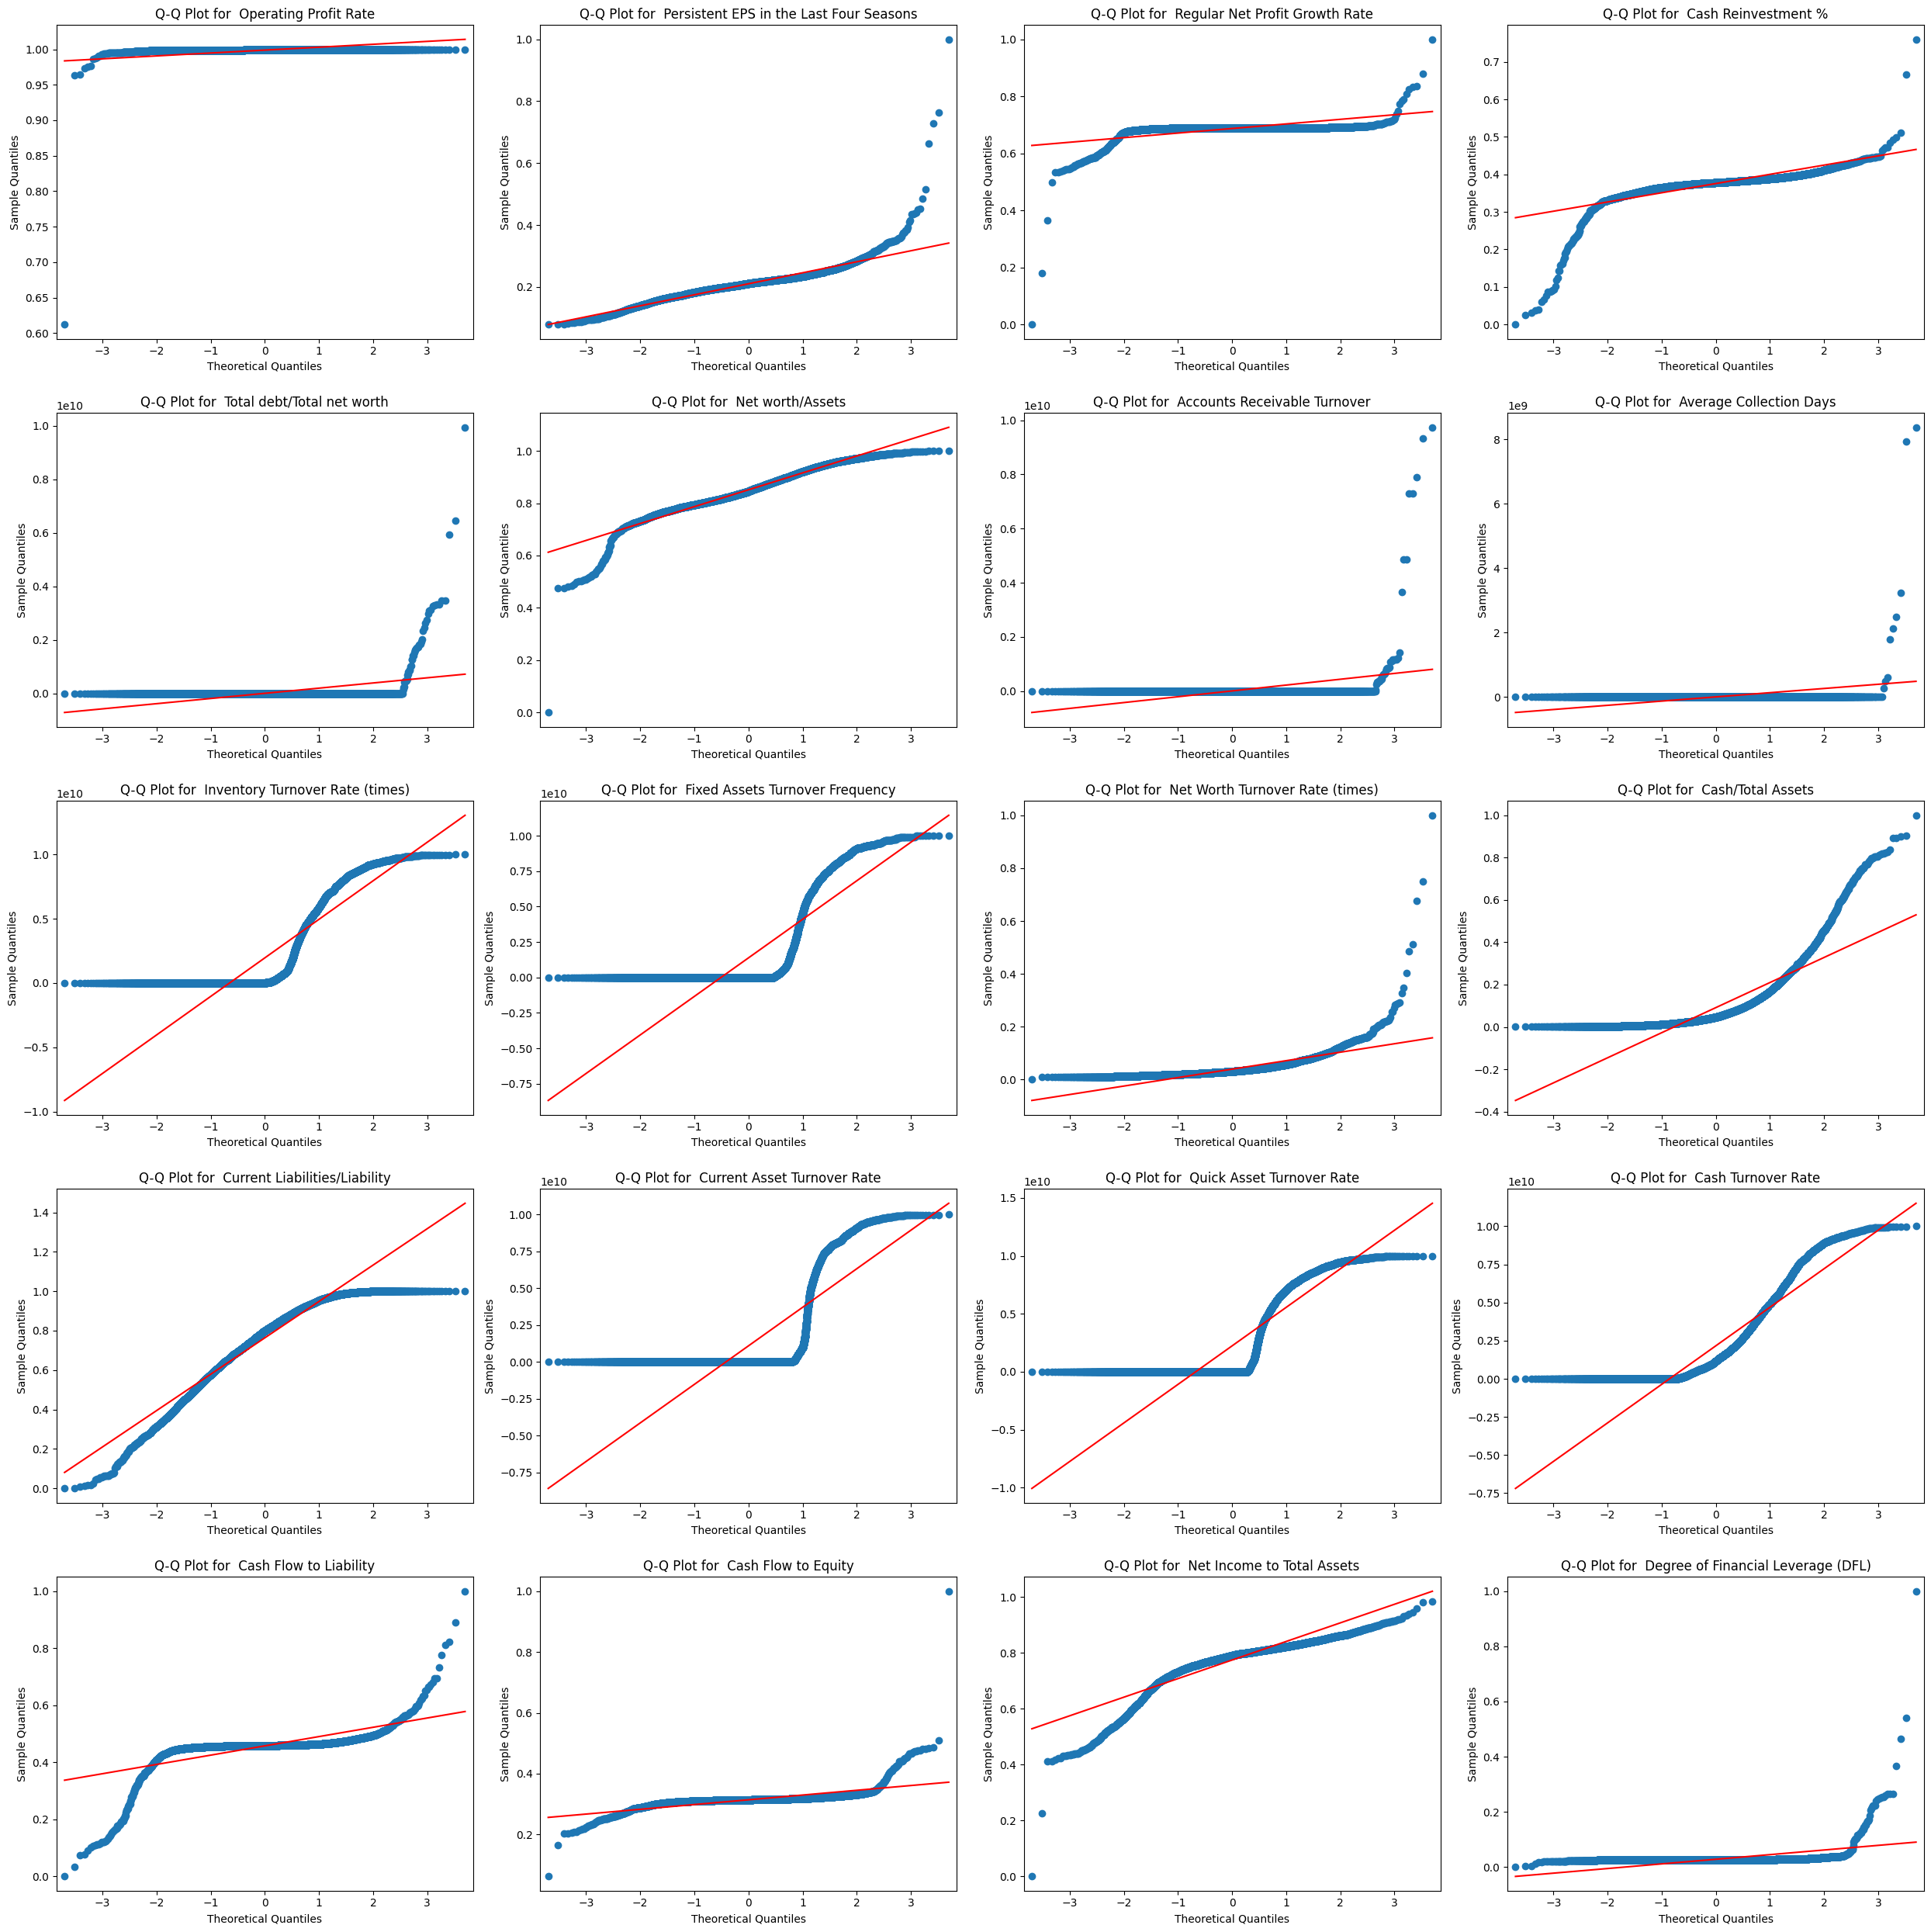

In [54]:
# Checking of Gaussian Assumption for LDA , QDA

num_rows, num_cols = 5, 4
numeric_columns = X_train1.columns
# Create a grid of Q-Q plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 25))
fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing between subplots

# Loop through the numeric columns and create Q-Q plots in the grid
for i, column in enumerate(numeric_columns):
    row, col = divmod(i, num_cols)  # Calculate the row and column index
    ax = axes[row, col]  # Get the current subplot
    sm.qqplot(X_train1[column], line='s', ax=ax)
    ax.set_title(f'Q-Q Plot for {column}')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Sample Quantiles')

plt.tight_layout()
plt.show()

In [66]:
#LDA

lda=LinearDiscriminantAnalysis(store_covariance=True)
lda.fit(X_train2,Y_train2)


LinearDiscriminantAnalysis(store_covariance=True)

In [67]:
lda.coef_

array([[ 0.07575045, -0.70570057,  0.25181465, -0.0344133 ,  0.170338  ,
        -2.07775372, -0.14052432, -0.06456229, -0.17503133,  0.47321501,
        -0.64083379, -0.21364589,  0.51869167, -0.13094952, -0.1487936 ,
        -0.62761374, -0.30002047, -0.23106398, -0.85740791,  0.1098158 ]])

In [68]:
y_prob_lda=lda.predict_proba(X_test2)[:,1]

In [69]:
fpr_lda, tpr_lda, thresholds_lda = roc_curve(Y_test2, y_prob_lda)
roc_auc_lda = auc(fpr_lda, tpr_lda)

In [70]:
diff_lda=tpr_lda-fpr_lda
best_arg_lda=np.argmax(diff_lda)
opt_thresold_lda=thresholds_lda[best_arg_lda]
print("Best Threshold:", opt_thresold_lda)
print("Corresponding TPR/Sensitivity:", tpr_lda[best_arg_lda])
print("Corresponding Specificity:", 1-fpr_lda[best_arg_lda])

Best Threshold: 0.43174364279891725
Corresponding TPR/Sensitivity: 0.8846153846153846
Corresponding Specificity: 0.8440040650406504


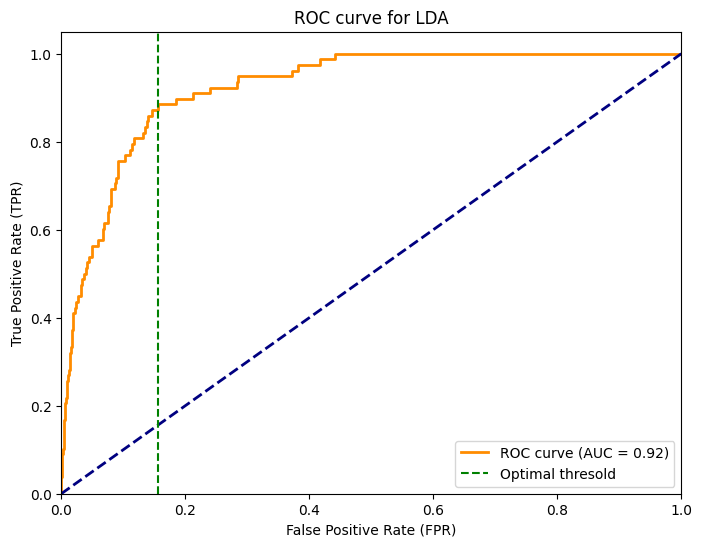

In [71]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_lda, tpr_lda, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_lda))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.axvline(x=fpr_lda[best_arg_lda], color='green', linestyle='--', label='Optimal thresold')
plt.legend(loc='lower right')
plt.title('ROC curve for LDA')
plt.legend(loc='lower right')
plt.show()

In [72]:
y_pred_lda_binary = (y_prob_lda >= thresholds_lda[best_arg_lda]).astype(int)
f1scoref1 = f1_score(Y_test2, y_pred_lda_binary)
print("F1 score:", f1scoref1)

F1 score: 0.3039647577092511


In [73]:
cm_lda=confusion_matrix(Y_test2, y_pred_lda_binary)

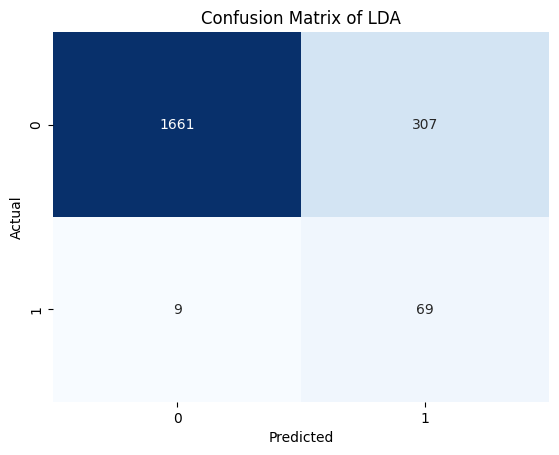

In [75]:
sns.heatmap(cm_lda, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of LDA')
plt.show()

In [31]:
# QDA

qda=QuadraticDiscriminantAnalysis()
qda.fit(X_train2,Y_train2)

c:\users\arghadeep fadikar\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis()

In [32]:
y_prob_qda=qda.predict_proba(X_test2)[:,1]

In [33]:
fpr_qda, tpr_qda, thresholds_qda = roc_curve(Y_test2, y_prob_qda)
roc_auc_qda = auc(fpr_qda, tpr_qda)

In [34]:
diff_qda=tpr_qda-fpr_qda
best_arg_qda=np.argmax(diff_qda)
opt_thresold_qda=thresholds_qda[best_arg_qda]
print("Best Threshold:", opt_thresold_qda)
print("Corresponding TPR/Sensitivity:", tpr_qda[best_arg_qda])
print("Corresponding Specificity:", 1-fpr_qda[best_arg_qda])

Best Threshold: 0.9999999999997906
Corresponding TPR/Sensitivity: 0.5897435897435898
Corresponding Specificity: 0.8719512195121951


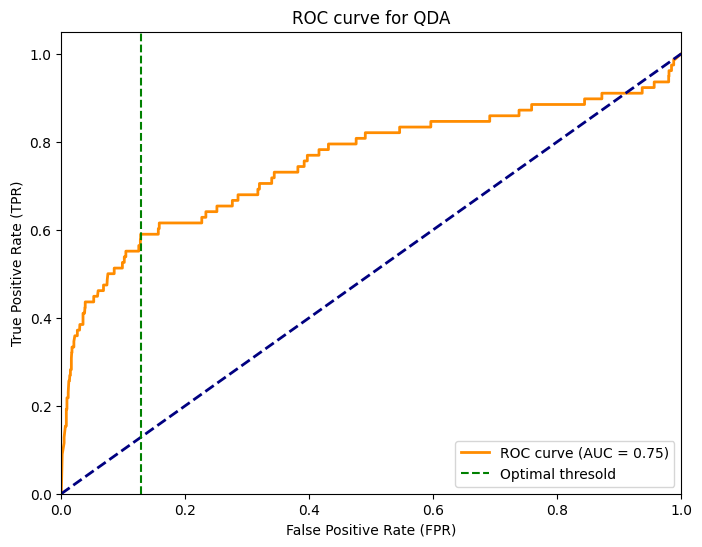

In [37]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_qda, tpr_qda, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_qda))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.axvline(x=fpr_qda[best_arg_qda], color='green', linestyle='--', label='Optimal thresold')
plt.legend(loc='lower right')
plt.title('ROC curve for QDA')
plt.legend(loc='lower right')
plt.show()

In [39]:
y_pred_qda_binary = (y_prob_qda >= thresholds_qda[best_arg_qda]).astype(int)
f1scoref1 = f1_score(Y_test2, y_pred_qda_binary)
print("F1 score:", f1scoref1)

F1 score: 0.2446808510638298


In [40]:
cm_qda=confusion_matrix(Y_test2, y_pred_qda_binary)

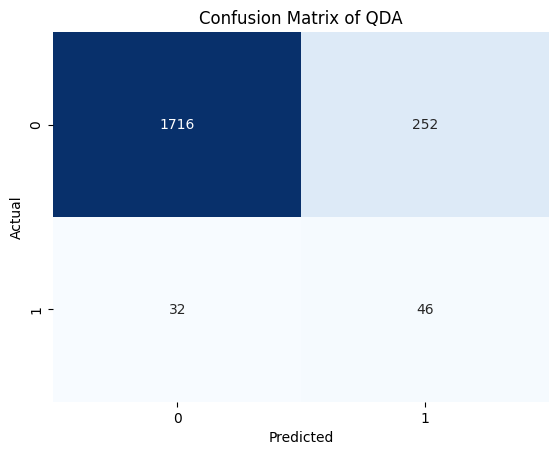

In [41]:
sns.heatmap(cm_qda, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of QDA')
plt.show()

In [68]:
nb=GaussianNB()
nb.fit(X_train2,Y_train2)

GaussianNB()

In [69]:
y_prob_nb=nb.predict_proba(X_test2)[:,1]

In [70]:
fpr_nb, tpr_nb, thresholds_nb = roc_curve(Y_test2, y_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

In [71]:
diff_nb=tpr_nb-fpr_nb
best_arg_nb=np.argmax(diff_nb)
opt_thresold_nb=thresholds_nb[best_arg_nb]
print("Best Threshold:", opt_thresold_nb)
print("Corresponding TPR/Sensitivity:", tpr_nb[best_arg_nb])
print("Corresponding Specificity:", 1-fpr_nb[best_arg_nb])

Best Threshold: 0.999999812581368
Corresponding TPR/Sensitivity: 0.782051282051282
Corresponding Specificity: 0.899390243902439


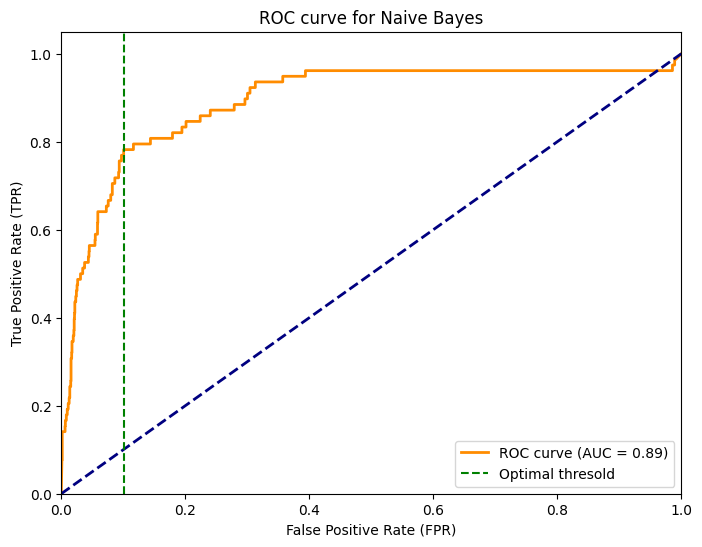

In [72]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_nb))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.axvline(x=fpr_nb[best_arg_nb], color='green', linestyle='--', label='Optimal thresold')
plt.legend(loc='lower right')
plt.title('ROC curve for Naive Bayes')
plt.legend(loc='lower right')
plt.show()

In [73]:
y_pred_nb_binary = (y_prob_nb >= thresholds_nb[best_arg_nb]).astype(int)
f1scoref1 = f1_score(Y_test2, y_pred_nb_binary)
print("F1 score:", f1scoref1)                  

F1 score: 0.3620178041543026


In [30]:
X_train_class_0 = X_train2[Y_train2 == 0]
X_train_class_1 = X_train2[Y_train2 == 1]

kde_class_0 = [KernelDensity(bandwidth=0.7).fit(X_train_class_0[:, i].reshape(-1, 1)) for i in range(X_train_class_0.shape[1])]
kde_class_1 = [KernelDensity(bandwidth=0.7).fit(X_train_class_1[:, i].reshape(-1, 1)) for i in range(X_train_class_1.shape[1])]

# Calculate the class priors from the training data
class_0_prior = np.sum(Y_train2 == 0) / len(Y_train2)
class_1_prior = 1 - class_0_prior

# Define the KD-NB classifier
def kd_naive_bayes_predict(new_instance):
    log_likelihood_class_0 = np.sum([kde.score_samples(new_instance[i].reshape(1, -1)) for i, kde in enumerate(kde_class_0)])
    log_likelihood_class_1 = np.sum([kde.score_samples(new_instance[i].reshape(1, -1)) for i, kde in enumerate(kde_class_1)])    
    posterior_class_0 = np.exp(log_likelihood_class_0) * class_0_prior
    posterior_class_1 = np.exp(log_likelihood_class_1) * class_1_prior
    
#    return 0 if posterior_class_0 > posterior_class_1 else 1
    return posterior_class_1

# Make predictions on the test data
predictions_nv = [kd_naive_bayes_predict(new_instance) for new_instance in X_test2]

# Calculate ROC curve
fpr_nv, tpr_nv, _ = roc_curve(Y_test2, predictions_nv)
roc_auc = auc(fpr_nv, tpr_nv)

# Plot ROC curve


In [32]:
kde_class_0

[KernelDensity(bandwidth=0.7),
 KernelDensity(bandwidth=0.7),
 KernelDensity(bandwidth=0.7),
 KernelDensity(bandwidth=0.7),
 KernelDensity(bandwidth=0.7),
 KernelDensity(bandwidth=0.7),
 KernelDensity(bandwidth=0.7),
 KernelDensity(bandwidth=0.7),
 KernelDensity(bandwidth=0.7),
 KernelDensity(bandwidth=0.7),
 KernelDensity(bandwidth=0.7),
 KernelDensity(bandwidth=0.7),
 KernelDensity(bandwidth=0.7),
 KernelDensity(bandwidth=0.7),
 KernelDensity(bandwidth=0.7),
 KernelDensity(bandwidth=0.7),
 KernelDensity(bandwidth=0.7),
 KernelDensity(bandwidth=0.7),
 KernelDensity(bandwidth=0.7),
 KernelDensity(bandwidth=0.7)]

In [201]:
diff_nv=tpr_nv-fpr_nv
best_arg_nv=np.argmax(diff_nv)
opt_thresold_nv=_[best_arg_nv]
print("Best Threshold:", opt_thresold_nv)
print("Corresponding TPR/Sensitivity:", tpr_nv[best_arg_nv])
print("Corresponding Specificity:", 1-fpr_nv[best_arg_nv])

Best Threshold: 1.932588662511405e-09
Corresponding TPR/Sensitivity: 0.44871794871794873
Corresponding Specificity: 0.7606707317073171


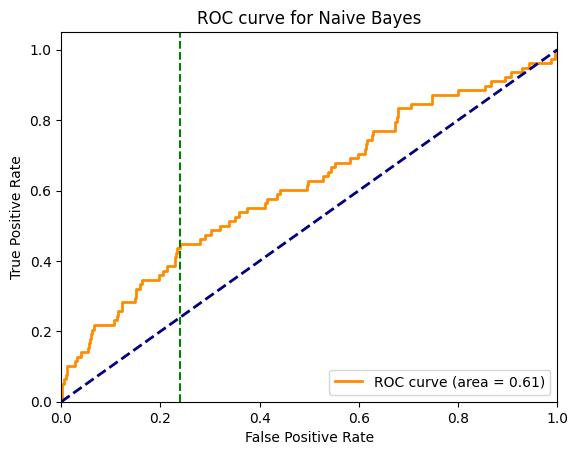

In [209]:
plt.figure()
plt.plot(fpr_nv, tpr_nv, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Naive Bayes')
plt.legend(loc='lower right')
plt.axvline(x=fpr_nv[best_arg_nv], color='green', linestyle='--', label='Optimal thresold')
plt.show()



In [204]:
y_pred_nv_binary = (predictions_nv >= _[best_arg_nv]).astype(int)
f1scoref1 = f1_score(Y_test2, y_pred_nv_binary)
print("F1 score:", f1scoref1) 

F1 score: 0.11986301369863014


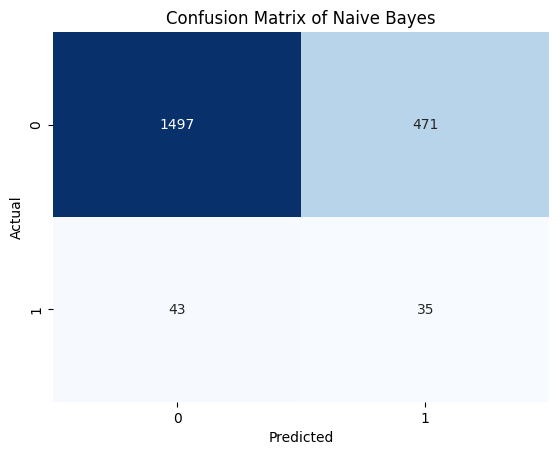

In [206]:
cm_nv=confusion_matrix(Y_test2, y_pred_nv_binary)
sns.heatmap(cm_nv, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Naive Bayes')
plt.show()

In [74]:
# Decesion Tree


dtree=DecisionTreeClassifier()

In [43]:
leaf=list(range(2,30))
dectree_metric=[]
for i in range(len(leaf)):
    dtree_i=DecisionTreeClassifier(max_leaf_nodes=leaf[i])
    dtree_i.fit(X_train2,Y_train2)
    y_prob_dtree_i=dtree_i.predict_proba(X_test2)[:,1]
    fpr_dtree_i, tpr_dtree_i, thresholds_dtree_i = roc_curve(Y_test2, y_prob_dtree_i)
    diff_dtree_i=tpr_dtree_i-fpr_dtree_i
    dectree_metric.append(max(diff_dtree_i))

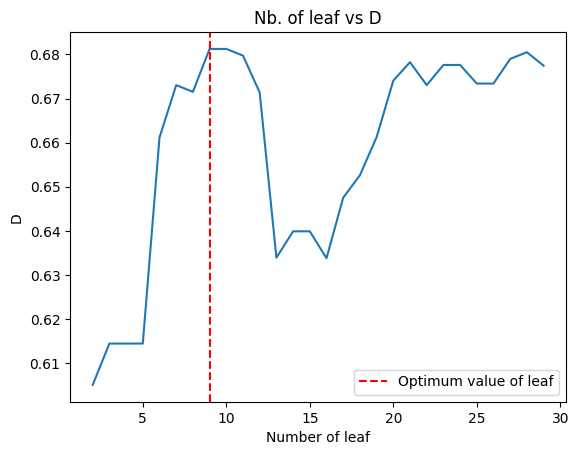

In [65]:
sns.lineplot(x=leaf,y=dectree_metric)
leaf_opt=leaf[np.argmax(np.array(dectree_metric))]
plt.axvline(x=leaf_opt, color='red', linestyle='--', label='Optimum value of leaf')
plt.legend()
plt.xlabel("Number of leaf")
plt.ylabel("D")
plt.title("Nb. of leaf vs D")
plt.show()

In [96]:
leaf=list(range(2,30))
dectree_metric1=[]
for i in range(len(leaf)):
    dtree_i=DecisionTreeClassifier(max_leaf_nodes=leaf[i])
    dtree_i.fit(X_train2,Y_train2)
    y_prob_dtree_i=dtree_i.predict_proba(X_test2)[:,1]
    fpr_dtree_i, tpr_dtree_i, thresholds_dtree_i = roc_curve(Y_test2, y_prob_dtree_i)
    diff_dtree_i=tpr_dtree_i-fpr_dtree_i
    dectree_metric1.append(auc(fpr_dtree_i, tpr_dtree_i))

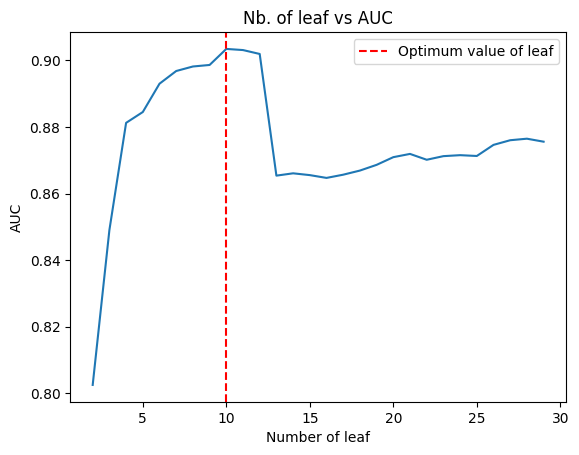

In [140]:
sns.lineplot(x=leaf,y=dectree_metric1)
leaf_opt=leaf[np.argmax(np.array(dectree_metric1))]
plt.axvline(x=leaf_opt, color='red', linestyle='--', label='Optimum value of leaf')
plt.legend()
plt.xlabel("Number of leaf")
plt.ylabel("AUC")
plt.title("Nb. of leaf vs AUC")
plt.show()

In [99]:
leaf_opt

10

In [75]:
# depth=list(range(1,20))
# leaf=list(range(2,30))
# parameter={
#     #'max_depth':depth
#     'max_leaf_nodes':leaf
# }
# cv=GridSearchCV(dtree,param_grid=parameter,scoring="accuracy",cv=10)

In [76]:
cv.fit(X_train2,Y_train2)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29]},
             scoring='accuracy')

In [77]:
cv.best_params_

{'max_leaf_nodes': 28}

In [78]:
cv.best_score_

0.9150310693591116

In [100]:
dtree1=DecisionTreeClassifier(max_leaf_nodes=leaf_opt)

In [101]:
dtree1.fit(X_train2,Y_train2)

DecisionTreeClassifier(max_leaf_nodes=10)

In [102]:
y_prob_dtree1=dtree1.predict_proba(X_test2)[:,1]

In [103]:
fpr_dtree1, tpr_dtree1, thresholds_dtree1 = roc_curve(Y_test2, y_prob_dtree1)
roc_auc_dtree1 = auc(fpr_dtree1, tpr_dtree1)

In [104]:
diff_dtree1=tpr_dtree1-fpr_dtree1
best_arg_dtree1=np.argmax(diff_dtree1)
opt_thresold_dtree1=thresholds_dtree1[best_arg_dtree1]
print("Best Threshold:", opt_thresold_dtree1)
print("Corresponding TPR/Sensitivity:", tpr_dtree1[best_arg_dtree1])
print("Corresponding Specificity:", 1-fpr_dtree1[best_arg_dtree1])

Best Threshold: 0.5996275605214153
Corresponding TPR/Sensitivity: 0.8717948717948718
Corresponding Specificity: 0.8094512195121951


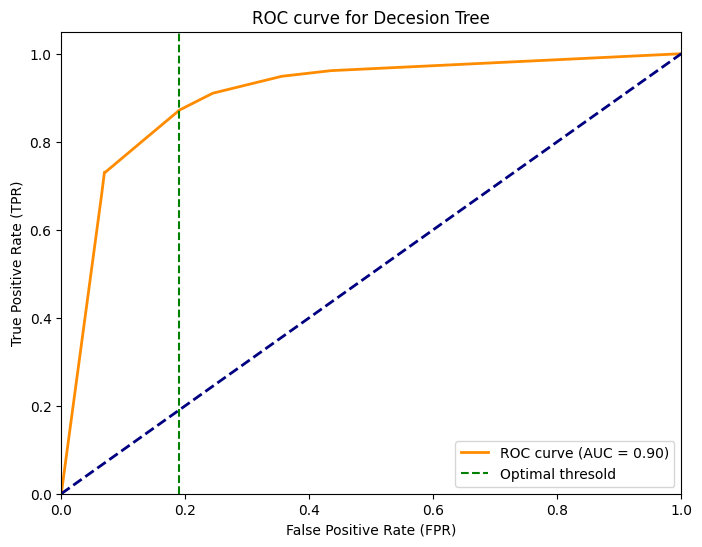

In [105]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_dtree1, tpr_dtree1, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_dtree1))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.axvline(x=fpr_dtree1[best_arg_dtree1], color='green', linestyle='--', label='Optimal thresold')
plt.legend(loc='lower right')
plt.title('ROC curve for Decesion Tree')
plt.legend(loc='lower right')
plt.show()

In [106]:
y_pred_dtree1_binary = (y_prob_dtree1 >= thresholds_dtree1[best_arg_dtree1]).astype(int)
f1scoref1 = f1_score(Y_test2, y_pred_dtree1_binary)
print("F1 score:", f1scoref1)

F1 score: 0.26103646833013433


In [107]:
dtree1.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.16078246, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01718617, 0.01775955, 0.        , 0.79001897, 0.01425286])

In [61]:
X_train1

,Operating Profit Rate,Persistent EPS in the Last Four Seasons,Regular Net Profit Growth Rate,Cash Reinvestment %,Total debt/Total net worth,Net worth/Assets,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Cash/Total Assets,Current Liabilities/Liability,Current Asset Turnover Rate,Quick Asset Turnover Rate,Cash Turnover Rate,Cash Flow to Liability,Cash Flow to Equity,Net Income to Total Assets,Degree of Financial Leverage (DFL)
0,0.999025,0.221329,0.689572,0.361807,0.005559,0.888200,0.000749,0.008438,2.195429e-04,3.366415e-04,0.033226,0.042824,0.851005,1.513277e-04,1.390382e-04,4.120000e+09,0.461584,0.316101,0.820175,0.026855
1,0.998971,0.209795,0.688642,0.376821,0.009680,0.847689,0.001045,0.006047,4.800000e+09,7.720000e+09,0.023548,0.046691,0.435276,1.788138e-04,9.680000e+09,8.370000e+09,0.457600,0.312648,0.789320,0.025910
2,0.999128,0.226624,0.689301,0.380425,0.001157,0.966895,0.001390,0.004553,1.199939e-04,2.345143e-04,0.022581,0.259714,0.902000,1.455298e-04,1.256330e-04,2.449644e-04,0.531309,0.325431,0.826516,0.026792
3,0.998895,0.208093,0.689096,0.375889,0.004246,0.906310,0.003873,0.001633,2.099893e-04,3.033556e-04,0.017258,0.034955,0.400899,1.052189e-04,9.590000e+09,7.040000e+09,0.449786,0.309716,0.794111,0.026101
4,0.999034,0.224449,0.689600,0.391574,0.006036,0.882396,0.001057,0.005982,5.355777e-04,1.344296e-03,0.050968,0.219729,0.997565,1.226587e-04,1.155984e-04,1.065306e-04,0.466422,0.319713,0.811586,0.026794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9257,0.998929,0.215927,0.689143,0.381962,0.014651,0.822710,0.001859,0.010664,6.050834e+08,1.043992e-03,0.016353,0.013626,0.881505,2.525266e-03,2.732609e-04,2.868421e+08,0.457790,0.311757,0.800805,0.026625
9258,0.997987,0.124316,0.685598,0.351290,0.128706,0.746233,0.000357,0.018577,5.572513e+09,7.053959e-04,0.032985,0.009583,0.916648,8.167102e+08,6.066595e+08,9.452490e+08,0.457727,0.291937,0.595324,0.026763
9259,0.998982,0.209094,0.689655,0.377263,0.017050,0.807673,0.001049,0.006312,1.574516e+07,6.419179e+08,0.041009,0.001254,0.460120,6.782013e+08,5.130081e+09,2.646627e+08,0.459149,0.314332,0.794164,0.028114
9260,0.998974,0.203845,0.688382,0.371867,0.009643,0.849543,0.003687,0.002400,5.842287e+08,7.708906e+09,0.027159,0.067086,0.773825,1.278559e-04,6.977642e+09,9.059738e+06,0.462314,0.317666,0.772201,0.026861


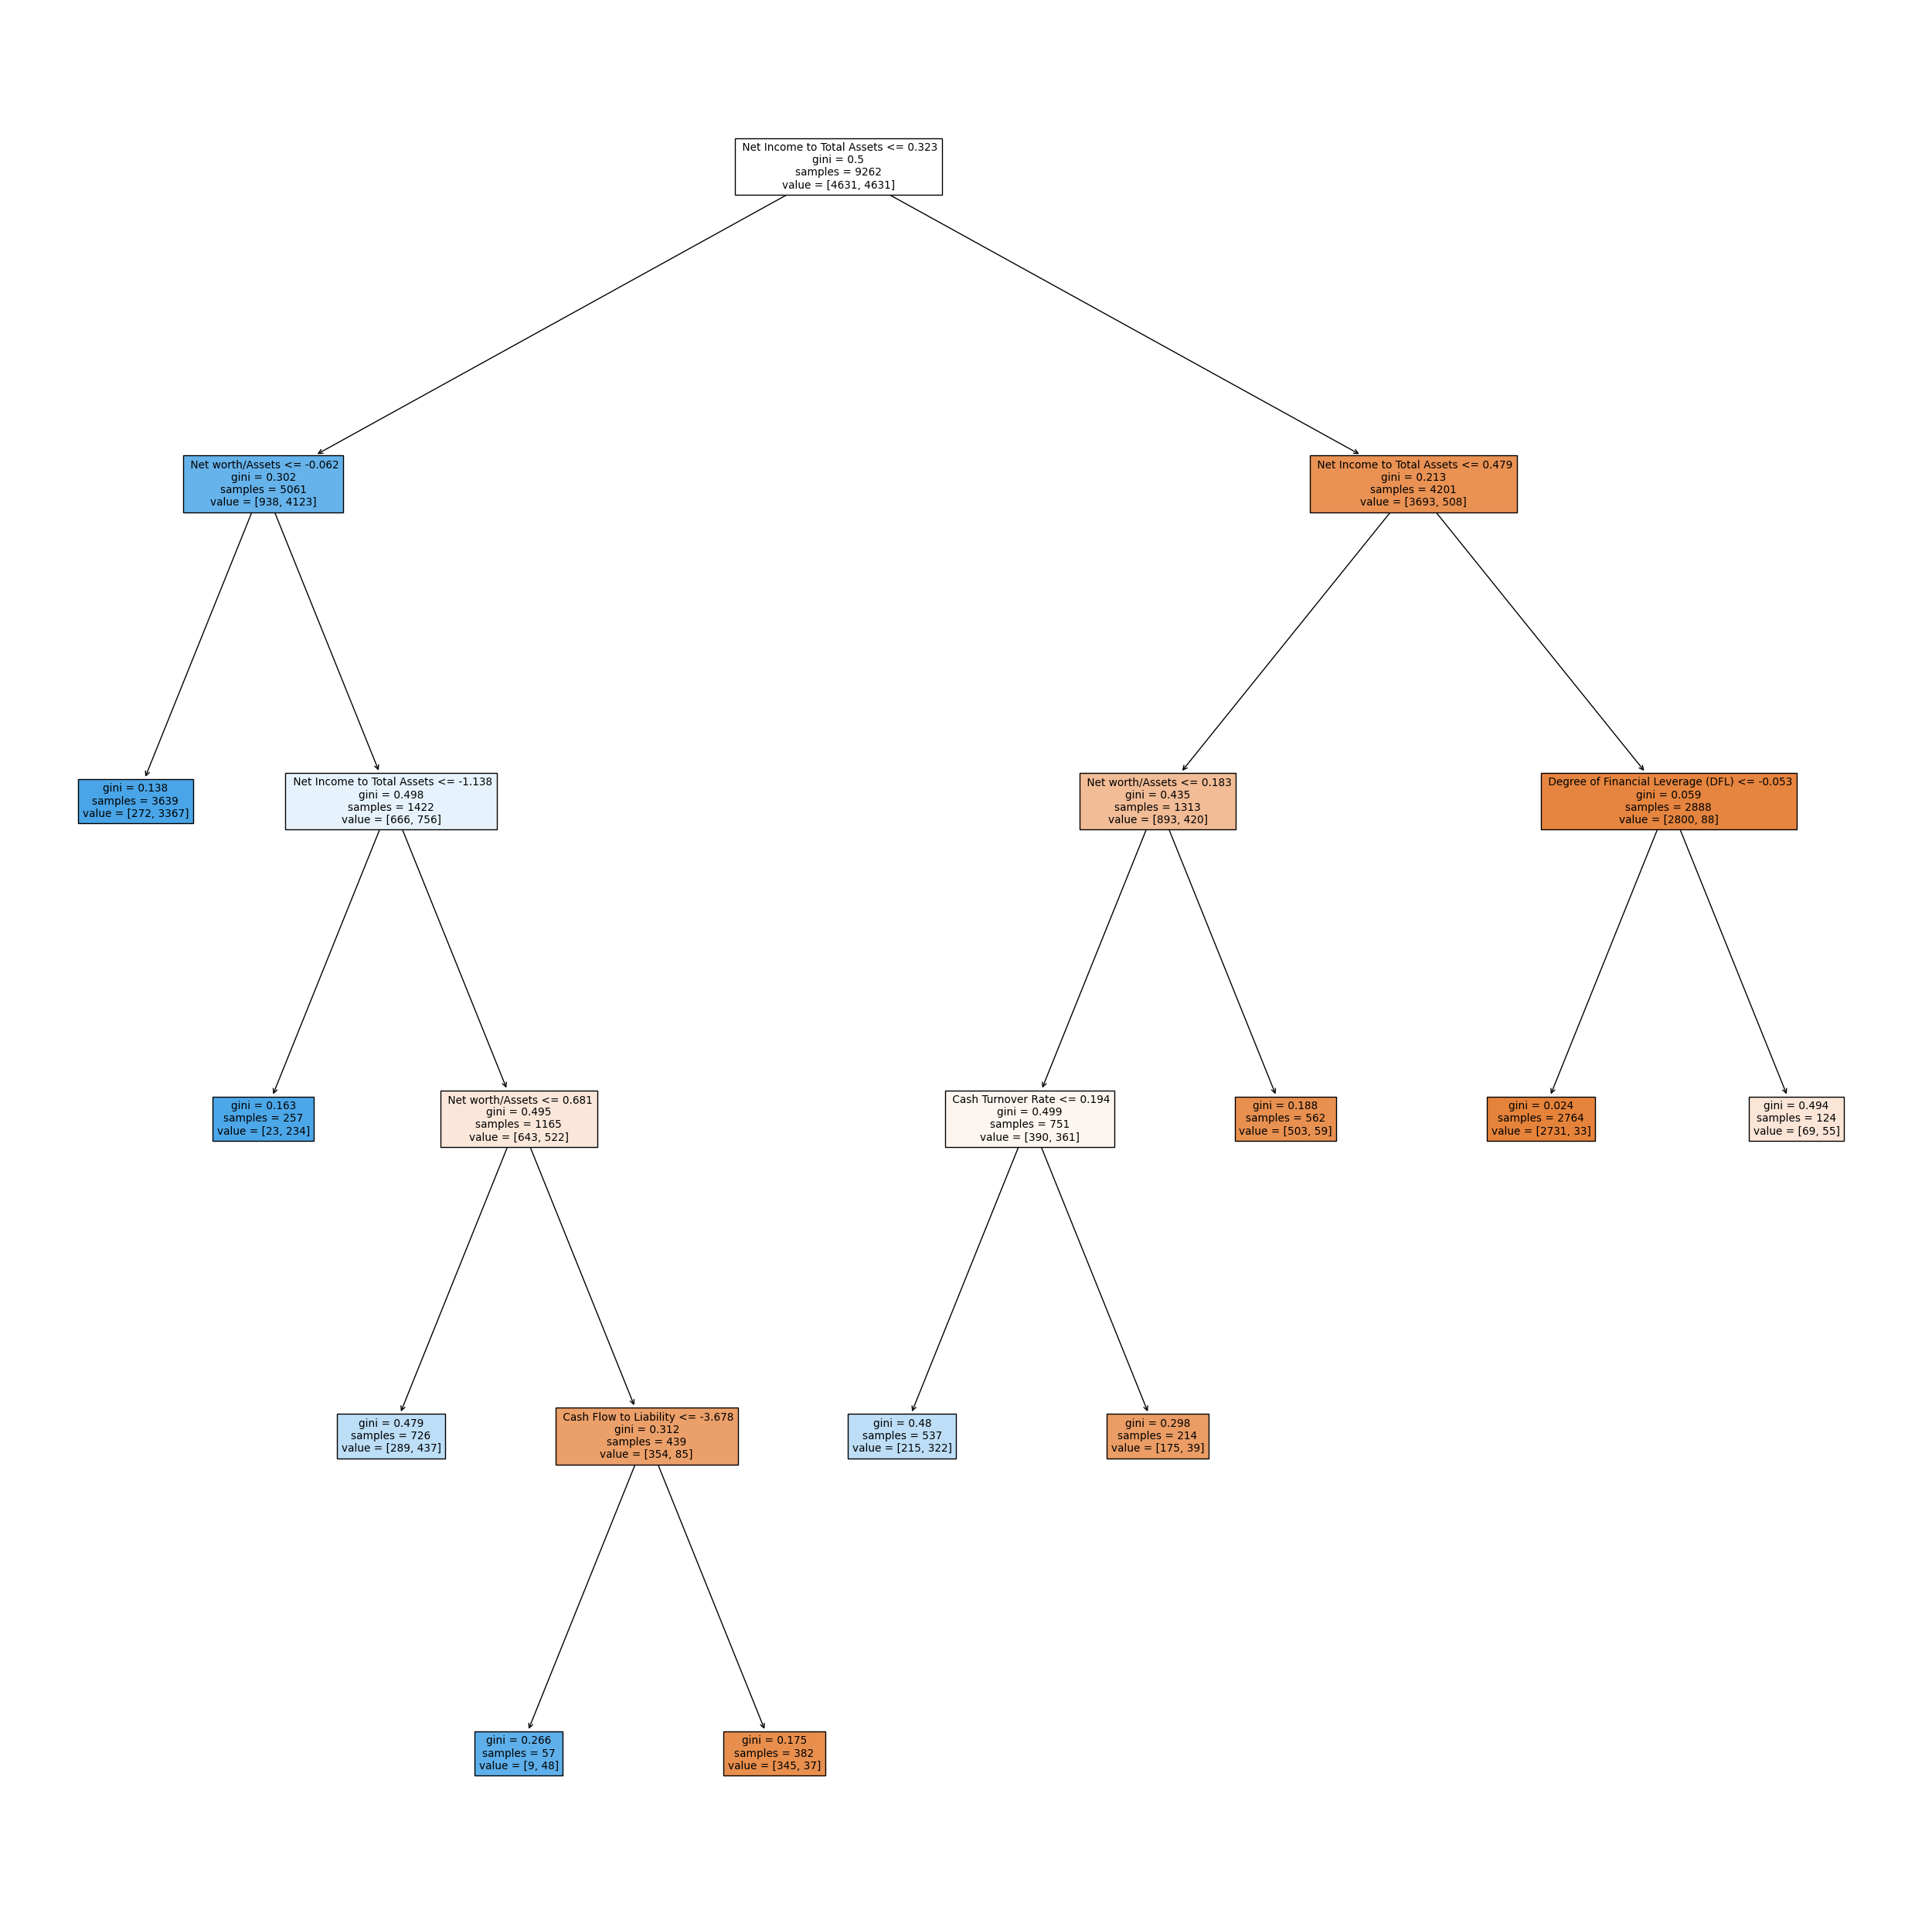

In [108]:
plt.figure(figsize=(32, 32))  # Adjust the figure size as needed
plot_tree(dtree1,feature_names=X_train1.columns,filled=True)
#plt.title("Regression tree before pruning")
plt.show()

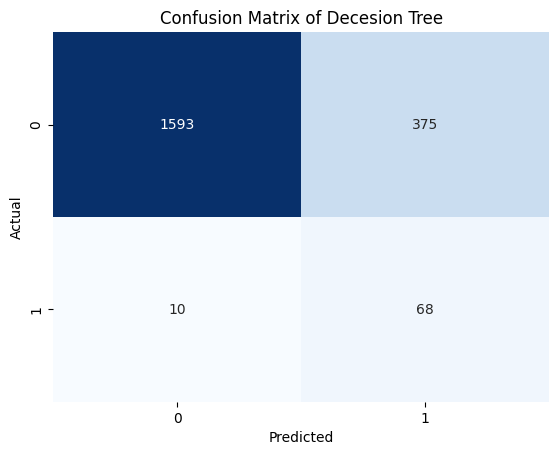

In [109]:
cm_tree=confusion_matrix(Y_test2, y_pred_dtree1_binary)
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Decesion Tree')
plt.show()

In [172]:
leaf=list(range(2,50))
rf_metric1=[]
for i in range(len(leaf)):
    rf_i=RandomForestClassifier(n_estimators=100,max_leaf_nodes=leaf[i])
    rf_i.fit(X_train2,Y_train2)
    y_prob_rf_i=rf_i.predict_proba(X_test2)[:,1]
    fpr_rf_i, tpr_rf_i, thresholds_rf_i = roc_curve(Y_test2, y_prob_rf_i)
    diff_rf_i=tpr_rf_i-fpr_rf_i
    rf_metric1.append(auc(fpr_rf_i, tpr_rf_i))

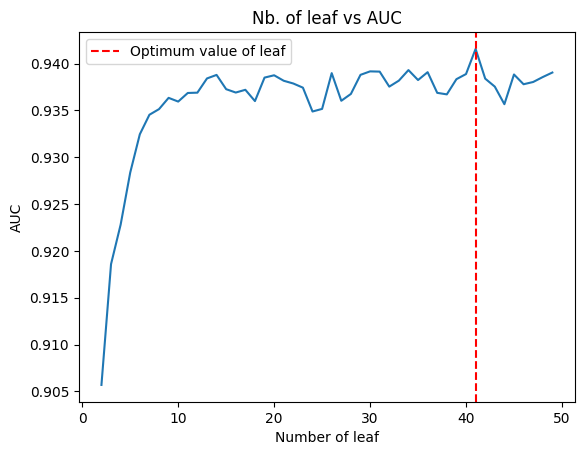

In [173]:
sns.lineplot(x=leaf,y=rf_metric1)
rf_opt1=leaf[np.argmax(np.array(rf_metric1))]
plt.axvline(x=rf_opt1, color='red', linestyle='--', label='Optimum value of leaf')
plt.legend()
plt.xlabel("Number of leaf")
plt.ylabel("AUC")
plt.title("Nb. of leaf vs AUC")
plt.show()

In [141]:
leaf=list(range(2,50))
rf_metric=[]
for i in range(len(leaf)):
    rf_i=RandomForestClassifier(n_estimators=100,max_leaf_nodes=leaf[i])
    rf_i.fit(X_train2,Y_train2)
    y_prob_rf_i=rf_i.predict_proba(X_test2)[:,1]
    fpr_rf_i, tpr_rf_i, thresholds_rf_i = roc_curve(Y_test2, y_prob_rf_i)
    diff_rf_i=tpr_rf_i-fpr_rf_i
    rf_metric.append(max(diff_rf_i))

In [ ]:
sns.lineplot(x=leaf,y=rf_metric)
rf_opt1=leaf[np.argmax(np.array(rf_metric))]
plt.axvline(x=rf_opt1, color='red', linestyle='--', label='Optimum value of leaf')
plt.legend()
plt.xlabel("Number of leaf")
plt.ylabel("AUC")
plt.title("Nb. of leaf vs AUC")
plt.show()

In [162]:
rf_opt1

26

In [163]:
# Random Forest


rf=RandomForestClassifier(n_estimators=100,max_leaf_nodes=rf_opt1)

In [164]:
rf.fit(X_train2,Y_train2)

RandomForestClassifier(max_leaf_nodes=26)

In [165]:
y_prob_rf=rf.predict_proba(X_test2)[:,1]

In [166]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y_test2, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

In [167]:
diff_rf=tpr_rf-fpr_rf
best_arg_rf=np.argmax(diff_rf)
opt_thresold_rf=thresholds_rf[best_arg_rf]
print("Best Threshold:", opt_thresold_rf)
print("Corresponding TPR/Sensitivity:", tpr_rf[best_arg_rf])
print("Corresponding Specificity:", 1-fpr_rf[best_arg_rf])

Best Threshold: 0.5148402373666295
Corresponding TPR/Sensitivity: 0.8974358974358975
Corresponding Specificity: 0.8958333333333334


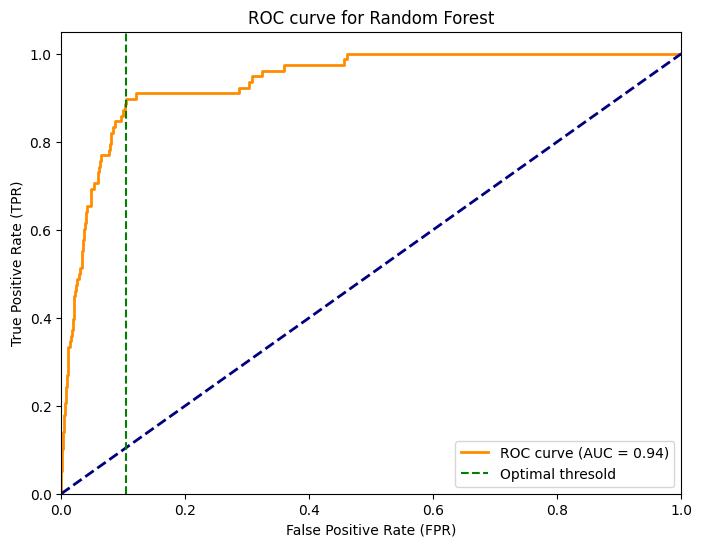

In [168]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_rf))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.axvline(x=fpr_rf[best_arg_rf], color='green', linestyle='--', label='Optimal thresold')
plt.legend(loc='lower right')
plt.title('ROC curve for Random Forest')
plt.legend(loc='lower right')
plt.show()

In [169]:
y_prob_rf=rf.predict_proba(X_test2)[:,1]
y_pred_rf_binary = (y_prob_rf >= thresholds_rf[best_arg_rf]).astype(int)
f1scoref1 = f1_score(Y_test2, y_pred_rf_binary)
print("F1 score:", f1scoref1)

F1 score: 0.3966005665722379


In [170]:
rf.feature_importances_

array([6.35503170e-02, 2.25209400e-01, 4.24709333e-02, 9.02879609e-03,
       8.35241984e-04, 1.83958067e-01, 4.10538118e-05, 0.00000000e+00,
       6.76563013e-03, 1.25580364e-02, 9.71593955e-03, 2.54416250e-02,
       1.28161794e-02, 2.94986350e-03, 3.17696918e-03, 5.05036427e-02,
       1.57678300e-02, 1.01232163e-02, 2.42852198e-01, 8.22350608e-02])

In [230]:
imp_rf=pd.DataFrame(rf.feature_importances_)
imp_rf.set_index(X_train1.columns,inplace=True)
imp_rf.columns=["Importance"]
imp_rf

,Importance
Operating Profit Rate,0.063550
Persistent EPS in the Last Four Seasons,0.225209
Regular Net Profit Growth Rate,0.042471
Cash Reinvestment %,0.009029
Total debt/Total net worth,0.000835
Net worth/Assets,0.183958
Accounts Receivable Turnover,0.000041
Average Collection Days,0.000000
Inventory Turnover Rate (times),0.006766
Fixed Assets Turnover Frequency,0.012558


In [238]:
imp_rf.to_excel("imp_rf.xlsx", sheet_name="1")

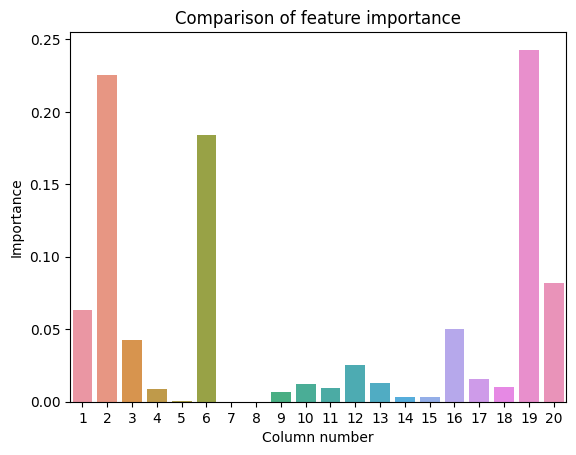

In [236]:
sns.barplot(x=list(range(1,21)),y=imp_rf["Importance"])
plt.xlabel("Column number")
plt.title("Comparison of feature importance")
plt.show()

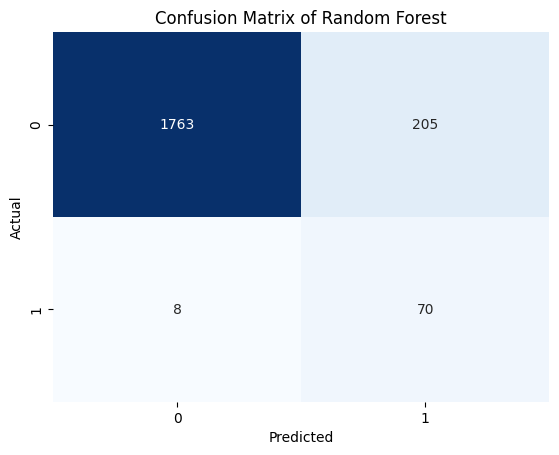

In [174]:
cm_rf=confusion_matrix(Y_test2, y_pred_rf_binary)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Random Forest')
plt.show()

In [86]:
# XG Boost
xgb = XGBClassifier()  # early_stopping_rounds=10,eval_metric='logloss'

In [211]:
# Hyperparameter tuning

param_grid1 = {
    'n_estimators':[200,250,300],
    'max_depth': [5,8,12],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1.0],
    "gamma":[0.1,0.5,1,5],
    "alpha":[0.1,0.5,1],
    #"learning_rate":[0.01,0.1,0.5]
}

In [212]:
grid_search1 = GridSearchCV(estimator=xgb, param_grid=param_grid1, scoring='roc_auc', cv=10)

# Fit the grid search to your data
grid_search1.fit(X_train2, Y_train2)

# Get the best parameters and best AUC score


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'alpha': [0.1, 0.5, 1], 'gamma': [0.1, 0.5, 1, 5],
                         'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [5, 8, 12],
                         'n_estimators': [200, 250, 300],
                         'subsample': [0.5, 0.7, 1.0]},
             scoring='roc_auc')

In [213]:
best_params1 = grid_search1.best_params_
best_auc1 = grid_search1.best_score_

# Print the results
print("Best Parameters:", best_params1)
print("Best AUC-ROC Score:", best_auc1)

Best Parameters: {'alpha': 0.1, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 300, 'subsample': 0.5}
Best AUC-ROC Score: 0.998548861566609


In [31]:
# For classification
xbst = XGBClassifier(alpha=0.1,gamma=0.1,learning_rate=0.1, max_depth=12, n_estimators=300, subsample=0.5)

In [32]:
xbst.fit(X_train2,Y_train2) 

XGBClassifier(alpha=0.1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [33]:
y_prob_xbst=xbst.predict_proba(X_test2)[:,1]

In [34]:
fpr_xbst, tpr_xbst, thresholds_xbst = roc_curve(Y_test2, y_prob_xbst)
roc_auc_xbst = auc(fpr_xbst, tpr_xbst)

In [35]:
diff_xbst=tpr_xbst-fpr_xbst
best_arg_xbst=np.argmax(diff_xbst)
opt_thresold_xbst=thresholds_xbst[best_arg_xbst]
print("Best Threshold:", opt_thresold_xbst)
print("Corresponding TPR/Sensitivity:", tpr_xbst[best_arg_xbst])
print("Corresponding Specificity:", 1-fpr_xbst[best_arg_xbst])

Best Threshold: 0.019159947
Corresponding TPR/Sensitivity: 0.8461538461538461
Corresponding Specificity: 0.8846544715447154


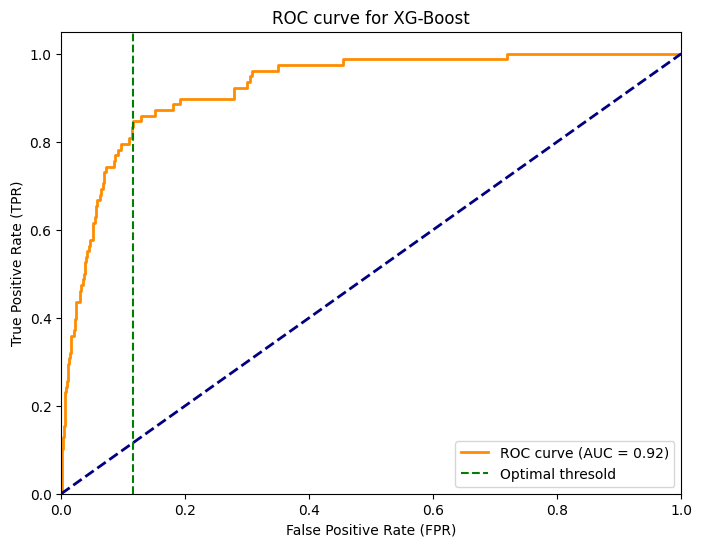

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_xbst, tpr_xbst, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_xbst))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.axvline(x=fpr_xbst[best_arg_xbst], color='green', linestyle='--', label='Optimal thresold')
plt.legend(loc='lower right')
plt.title('ROC curve for XG-Boost')
plt.legend(loc='lower right')
plt.show()

In [220]:
feature_importance = xbst.get_booster().get_score(importance_type='gain')

In [221]:
feature_importance 

{'f0': 1.8721975088119507,
 'f1': 2.8858258724212646,
 'f2': 1.5291804075241089,
 'f3': 1.530395269393921,
 'f4': 6.270263671875,
 'f5': 6.488688945770264,
 'f6': 1.8617115020751953,
 'f7': 0.210601806640625,
 'f8': 1.7880486249923706,
 'f9': 1.9424961805343628,
 'f10': 1.5101430416107178,
 'f11': 1.6924188137054443,
 'f12': 1.8962129354476929,
 'f13': 1.6876981258392334,
 'f14': 1.82023024559021,
 'f15': 2.8345603942871094,
 'f16': 2.0823252201080322,
 'f17': 1.9290937185287476,
 'f18': 27.79216957092285,
 'f19': 2.7661678791046143}

In [241]:
y_prob_xbst=xbst.predict_proba(X_test2)[:,1]
y_pred_xbst_binary = (y_prob_xbst >= thresholds_xbst[best_arg_xbst]).astype(int)
f1scoref1 = f1_score(Y_test2, y_pred_xbst_binary)
print("F1 score:", f1scoref1)

F1 score: 0.3557951482479784


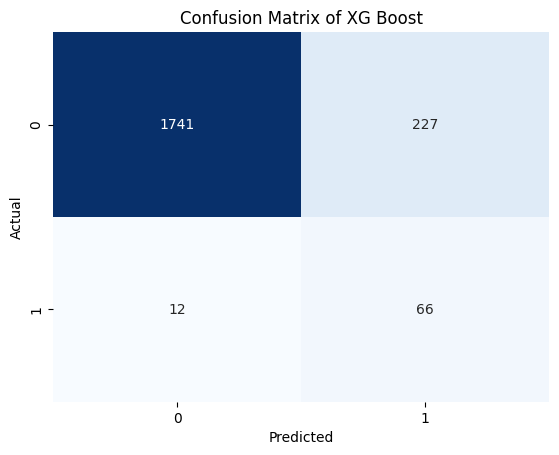

In [242]:
cm_xg=confusion_matrix(Y_test2, y_pred_xbst_binary)
sns.heatmap(cm_xg, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of XG Boost')
plt.show()

In [51]:


X.describe()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,...,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,...,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.505180,0.558625,0.553589,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,...,0.001173,0.807760,1.862942e+07,0.623915,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.060686,0.065620,0.061595,0.013010,0.012869,0.013601,0.011163,0.012679,3.237684e+09,2.598292e+09,...,0.034234,0.040332,3.764501e+08,0.012290,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.476527,0.535543,0.527277,0.998969,0.797386,0.809312,0.303466,0.781567,1.566874e-04,1.281880e-04,...,0.000000,0.796750,9.036205e-04,0.623636,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.502706,0.559802,0.552278,0.999022,0.797464,0.809375,0.303525,0.781635,2.777589e-04,5.090000e+08,...,0.000000,0.810619,2.085213e-03,0.623879,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.535563,0.589157,0.584105,0.999095,0.797579,0.809469,0.303585,0.781735,4.145000e+09,3.450000e+09,...,0.000000,0.826455,5.269777e-03,0.624168,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.990000e+09,9.980000e+09,...,1.000000,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


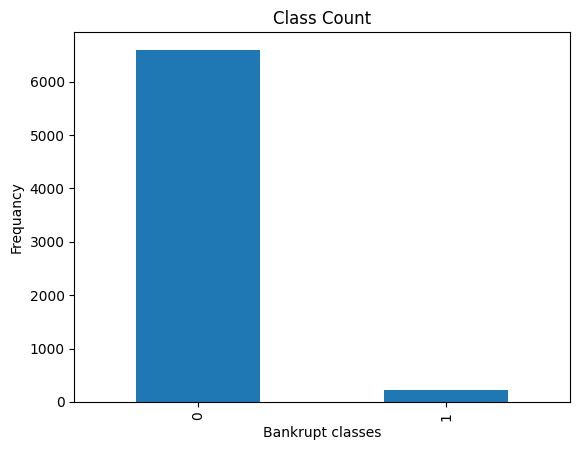

In [71]:
df['Bankrupt?'].value_counts().plot(kind= 'bar')
plt.xlabel("Bankrupt classes")
plt.ylabel("Frequancy")
plt.title("Class Count");

In [76]:


# # Fit a theoretical distribution to your data (you can choose a distribution that makes sense)
# # For example, let's use a normal distribution as an example
# params_class_0 = stats.norm.fit(x_class_0)
# theoretical_quantiles_class_0 = stats.norm.ppf(np.linspace(0.01, 0.99, len(x_class_0)), *params_class_0)
# sorted_data_class_0 = np.sort(x_class_0)

# # Create the Q-Q plot for class 0
# plt.figure()
# plt.scatter(sorted_data_class_0, theoretical_quantiles_class_0)
# plt.title("Q-Q Plot for Class 0")
# plt.xlabel("Theoretical Quantiles")
# plt.ylabel("Sample Quantiles")
# plt.show()

# # Repeat the process for class 1
# class_1_indices = np.where(Y_test2 == 1)
# x_class_1 = x_train1[class_1_indices]

# params_class_1 = stats.norm.fit(x_class_1)
# theoretical_quantiles_class_1 = stats.norm.ppf(np.linspace(0.01, 0.99, len(x_class_1)), *params_class_1)
# sorted_data_class_1 = np.sort(x_class_1)

# plt.figure()
# plt.scatter(sorted_data_class_1, theoretical_quantiles_class_1)
# plt.title("Q-Q Plot for Class 1")
# plt.xlabel("Theoretical Quantiles")
# plt.ylabel("Sample Quantiles")
# plt.show()

In [67]:
class_0_indices = np.where(Y_test2 == 0)
x_class_0 = X_train1.iloc[class_0_indices]
class_1_indices = np.where(Y_test2 == 1)
x_class_1 = X_train1.iloc[class_1_indices]

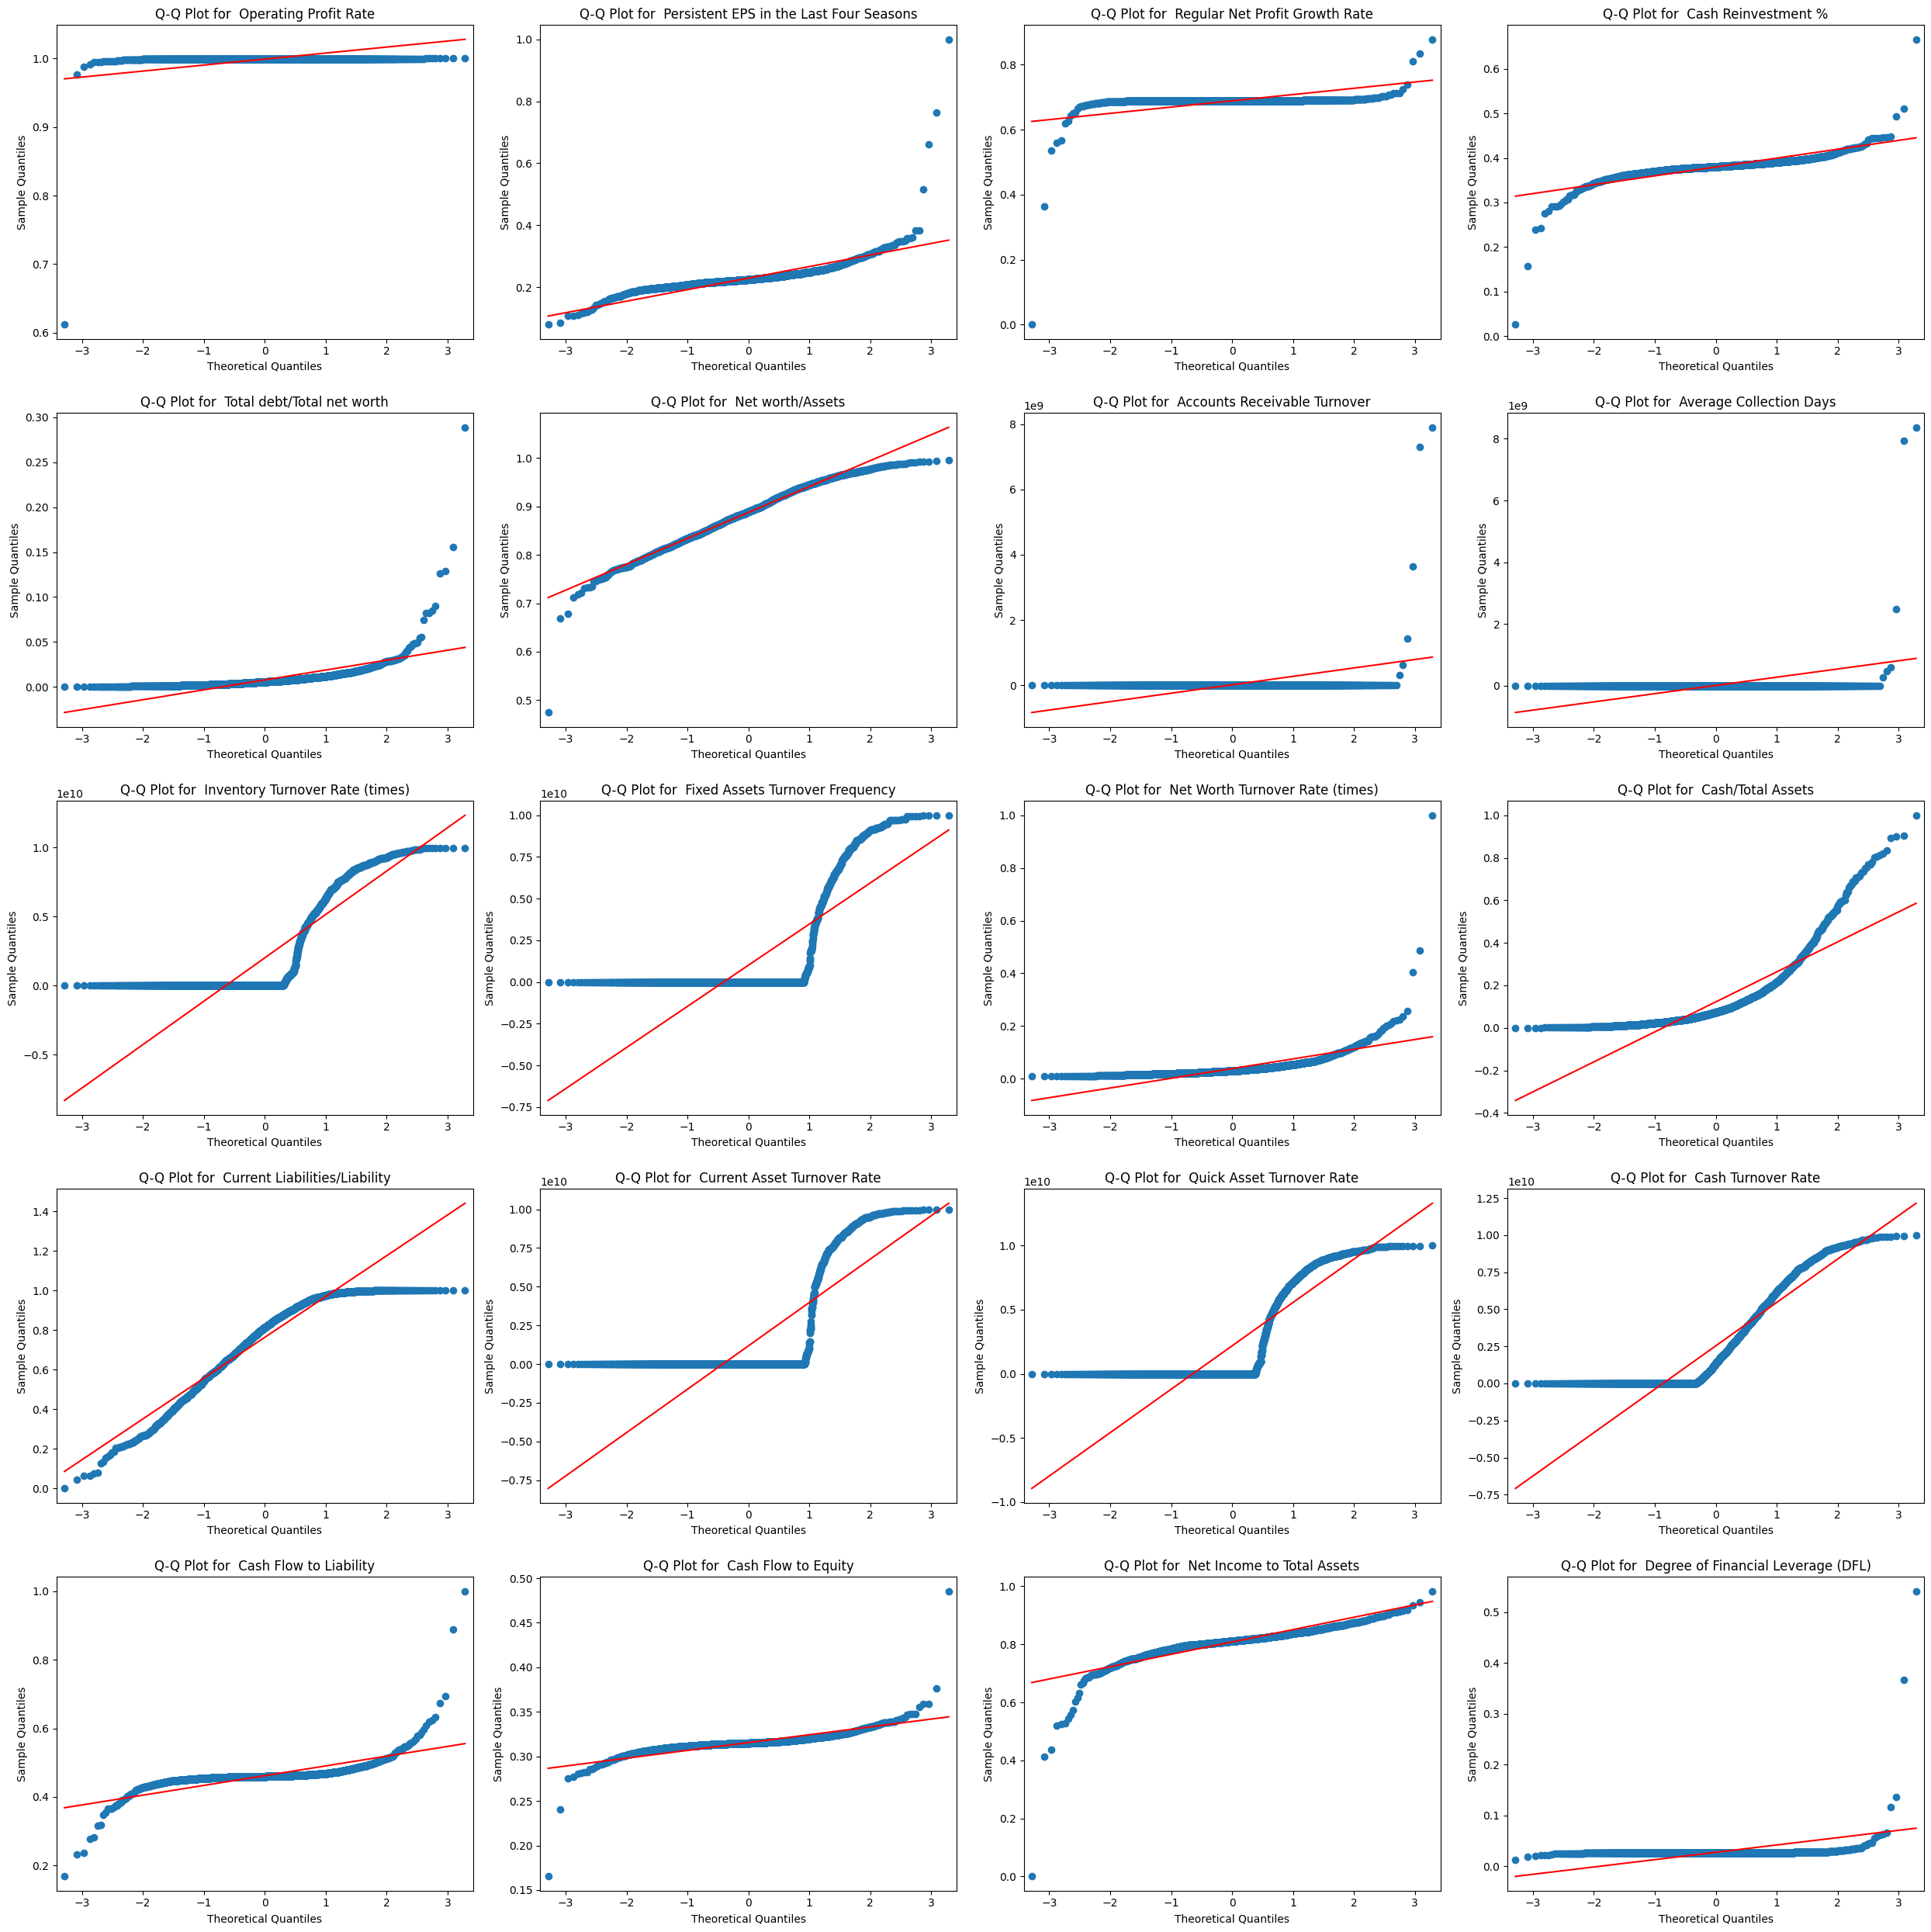

In [69]:
num_rows, num_cols = 5, 4
numeric_columns = x_class_0.columns
# Create a grid of Q-Q plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 25))
fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing between subplots

# Loop through the numeric columns and create Q-Q plots in the grid
for i, column in enumerate(numeric_columns):
    row, col = divmod(i, num_cols)  # Calculate the row and column index
    ax = axes[row, col]  # Get the current subplot
    sm.qqplot(x_class_0[column], line='s', ax=ax)
    ax.set_title(f'Q-Q Plot for {column}')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Sample Quantiles')

plt.tight_layout()
plt.show()

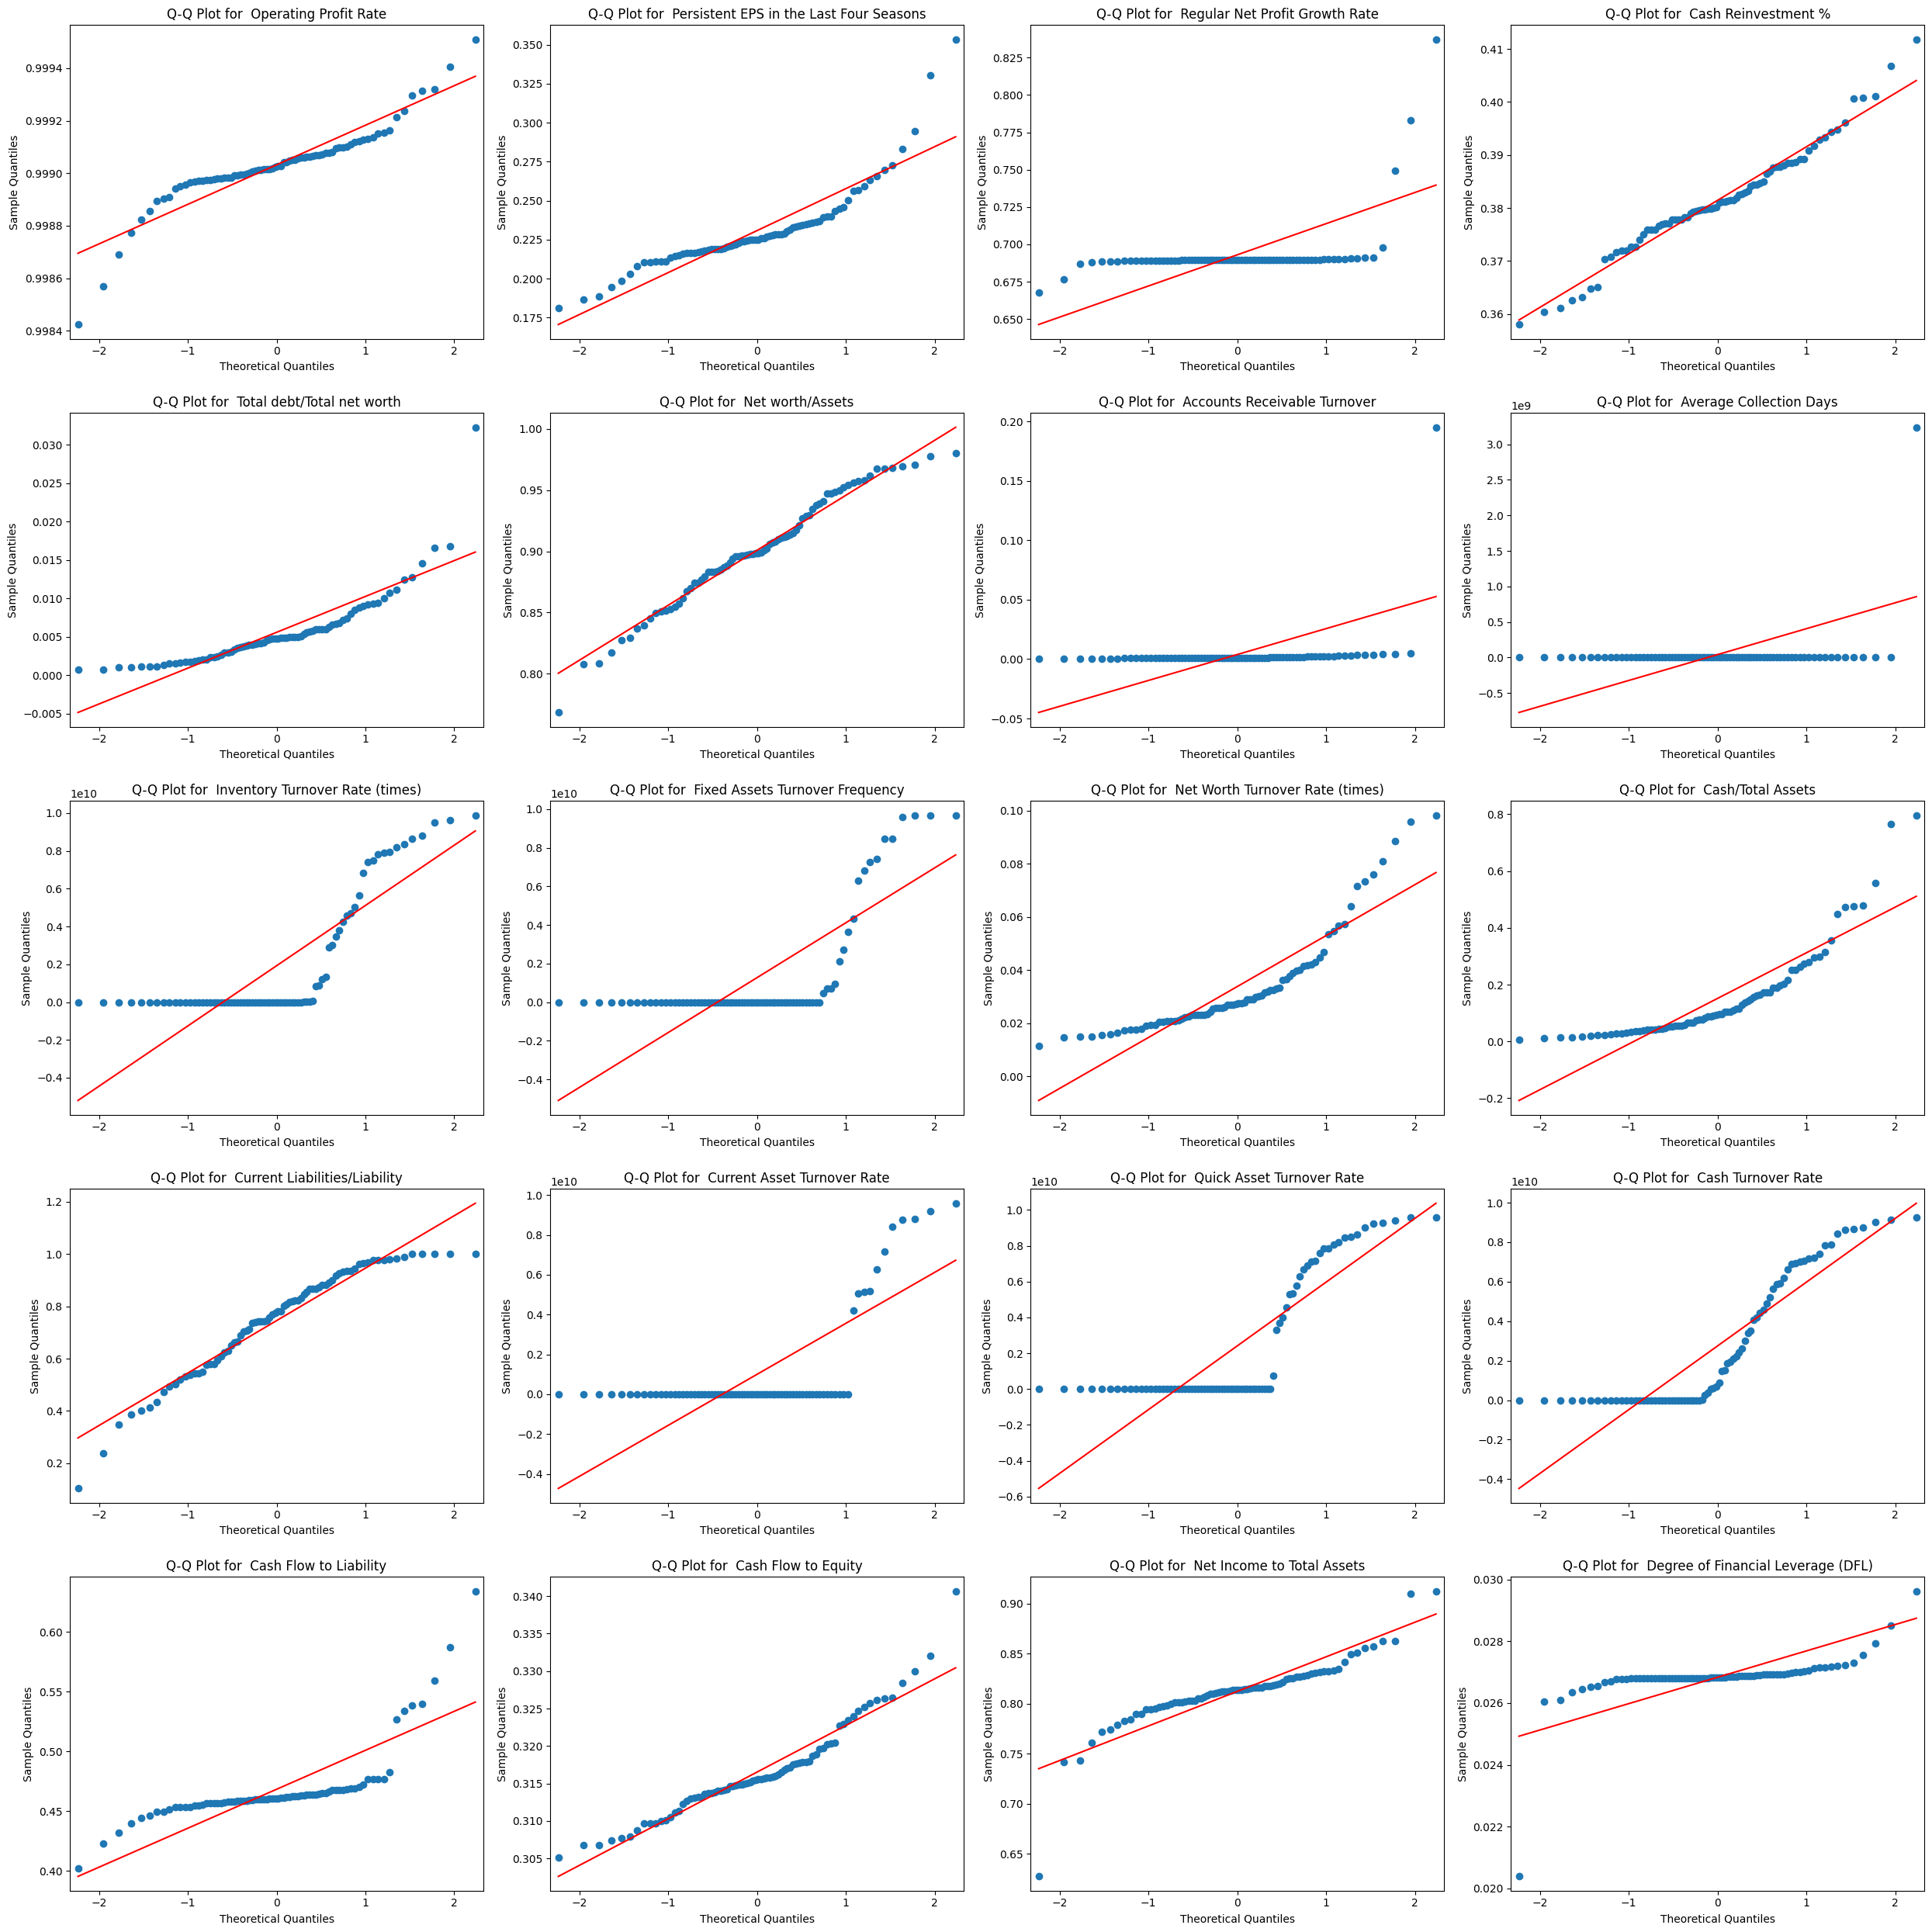

In [70]:
num_rows, num_cols = 5, 4
numeric_columns = x_class_1.columns
# Create a grid of Q-Q plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 25))
fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing between subplots

# Loop through the numeric columns and create Q-Q plots in the grid
for i, column in enumerate(numeric_columns):
    row, col = divmod(i, num_cols)  # Calculate the row and column index
    ax = axes[row, col]  # Get the current subplot
    sm.qqplot(x_class_1[column], line='s', ax=ax)
    ax.set_title(f'Q-Q Plot for {column}')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Sample Quantiles')

plt.tight_layout()
plt.show()

In [72]:
cov_matrix_0 = np.cov(x_class_0, rowvar=False)
cov_matrix_1 = np.cov(x_class_1, rowvar=False)

In [75]:
pd.DataFrame(cov_matrix_0-cov_matrix_1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,7.650273e-05,7.439334e-06,8.689323e-07,3.822547e-06,-8.376601e-07,8.374183e-06,-1.248817e+04,-2.317480e+03,2.284798e+05,1.406186e+05,6.801681e-06,2.057058e-05,-4.070257e-05,2.256249e+05,5.096823e+05,6.206823e+05,9.237152e-06,8.387015e-06,1.302738e-05,2.061070e-07
1,7.439334e-06,6.553120e-04,2.264131e-05,2.342213e-05,-6.468932e-05,2.491673e-04,-9.860280e+04,-5.887401e+05,-7.883191e+06,4.016176e+06,-1.221869e-04,3.146551e-04,-2.681543e-04,5.342327e+06,-1.185957e+07,-3.818165e+06,-1.508395e-05,3.951831e-05,2.816499e-04,-1.191789e-05
2,8.689323e-07,2.264131e-05,-6.774514e-05,-1.533306e-06,-8.906543e-06,-6.132346e-06,-2.142340e+05,1.568692e+05,6.932239e+06,-2.430630e+06,8.255308e-05,4.346607e-04,1.669269e-03,-1.209606e+07,-1.401494e+07,-3.077164e+05,5.286419e-05,1.095794e-06,-2.503315e-07,6.461177e-07
3,3.822547e-06,2.342213e-05,-1.533306e-06,2.937741e-04,-4.611701e-06,6.510378e-06,-4.085537e+04,1.201016e+06,-7.937465e+06,-2.208376e+06,1.448135e-04,4.592705e-04,1.884949e-04,7.899821e+05,-3.944845e+06,-2.771339e+06,1.203173e-04,5.891420e-05,4.251194e-05,1.022695e-06
4,-8.376601e-07,-6.468932e-05,-8.906543e-06,-4.611701e-06,9.947094e-05,-1.963639e-04,3.986997e+04,-1.273278e+05,-2.638245e+06,-1.077163e+05,1.177043e-04,-2.958136e-05,-6.975839e-06,1.445181e+06,3.791380e+06,-2.035209e+06,2.123546e-05,-5.037602e-06,-1.314897e-04,-1.712370e-07
5,8.374183e-06,2.491673e-04,-6.132346e-06,6.510378e-06,-1.963639e-04,8.230402e-04,-1.720566e+05,1.813497e+06,1.565321e+07,1.030762e+06,-3.899255e-04,-7.061751e-04,1.092144e-03,-1.269238e+07,-2.481166e+07,1.276098e+07,-3.911221e-04,-3.608894e-05,5.552004e-04,-1.345074e-05
6,-1.248817e+04,-9.860280e+04,-2.142340e+05,-4.085537e+04,3.986997e+04,-1.720566e+05,6.681854e+16,-1.102557e+14,-1.834660e+16,-5.153215e+15,-2.889334e+05,-1.148410e+06,-1.610775e+06,-1.267997e+16,-2.348737e+16,-1.533316e+16,-2.953172e+04,-1.042016e+04,-1.428818e+05,-9.261528e+03
7,-2.317480e+03,-5.887401e+05,1.568692e+05,1.201016e+06,-1.273278e+05,1.813497e+06,-1.102557e+14,-6.355999e+16,3.559657e+16,4.462822e+16,1.566779e+05,3.507196e+06,-8.020837e+06,6.179760e+16,-1.114687e+17,-1.560049e+17,4.048633e+05,1.291687e+05,-4.710770e+05,-1.403119e+03
8,2.284798e+05,-7.883191e+06,6.932239e+06,-7.937465e+06,-2.638245e+06,1.565321e+07,-1.834660e+16,3.559657e+16,-4.011246e+17,-1.697923e+17,-9.153986e+06,1.593302e+07,5.492260e+07,5.843802e+17,1.261924e+18,4.941305e+17,9.879265e+06,7.551344e+04,-8.816622e+06,4.218194e+05
9,1.406186e+05,4.016176e+06,-2.430630e+06,-2.208376e+06,-1.077163e+05,1.030762e+06,-5.153215e+15,4.462822e+16,-1.697923e+17,-2.101605e+18,-7.373781e+05,-4.496544e+06,-3.576585e+07,-9.197747e+17,9.882947e+17,-7.698734e+17,7.556030e+06,1.430077e+06,9.205307e+05,-5.872571e+05
